In [1]:
import os
import fastavro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from correction.compute import *

In [2]:
from multiprocessing import Pool, cpu_count

def applyParallel(dfGrouped, func):
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Extract SNe

In [4]:
#!pip install psycopg2-binary
import psycopg2

In [5]:
import json
credentials_file = "../../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [6]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [7]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper_invert = dict(zip(classes.id.tolist(), classes.name.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'Blazar': 8,
 'CV/Nova': 9,
 'SLSN': 14,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22,
 'SNIa': 10,
 'SNIbc': 11,
 'SNII': 12,
 'SNIIn': 13,
 'EBSD/D': 15,
 'EBC': 16,
 'Periodic-Other': 17,
 'AGN-I': 7,
 'RS-CVn': 23,
 'QSO-I': 24}

In [8]:
query='''
select oid
from objects
where classrf in ('%i', '%i', '%i', '%i')
''' % (classmapper["SNIa"], classmapper["SNIbc"], classmapper["SNII"], classmapper["SLSN"])
sn = pd.read_sql_query(query, conn)
display(sn.head())
sn.shape

,oid
0,ZTF19aattvhh
1,ZTF19abvbraf
2,ZTF20aafujbt
3,ZTF19adazxnz
4,ZTF18ablvirg


(7593, 1)

In [9]:
#data = pd.read_csv("../data_examples/csv/raw_detections.csv", index_col=False)
#'ZTF19aazzpje' #'ZTF20aaelulu' #'ZTF19aazzpje' # SN
#'ZTF18aaiscil' # weird
#'ZTF18abdgukn' # AGN
#'ZTF17aaaedmd' # LPV
#"ZTF19abaejrh"
#"ZTF20aaelulu"

# Work with test parquets

In [10]:
det = pd.read_parquet("./det_sample.parquet")
det["mjd"] = det.jd - 2400000.5

In [11]:
non_det = pd.read_parquet("./non_det_sample.parquet")
non_det["mjd"] = non_det.jd - 2400000.5

In [12]:
# check for oid in non_det missing from det
len(set(non_det.objectId.unique()).difference(set(det.objectId.unique())))

0

In [13]:
# count number of detections
ndet = det.groupby("objectId").apply(len)

In [14]:
# select a given number of oids
#seloid = ndet[ndet > 5].index.values
seloid = sn.oid.values#[:1000]

In [15]:
# filter detections
det = det.loc[det.objectId.isin(seloid)].copy()
non_det = non_det.loc[non_det.objectId.isin(seloid)][["objectId", "fid", "mjd", "diffmaglim"]].copy()

In [16]:
det.head()

,objectId,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,...,szmag3,sgscore3,distpsnr3,nmtchps,rfid,jdstartref,jdendref,nframesref,parent_candid,mjd
194884,ZTF18aaxnqjb,2.458272e+06,2,517190705815,20.349472,ztf_20180602190694_000579_zr_c15_o_q3_scimrefd...,Kulkarni,1,517190705815015022,t,...,19.014299,0.5,3.547927,8,579120258,2.458159e+06,2.458218e+06,16,0,58271.190706
194885,ZTF18aaxnqjb,2.458275e+06,2,520191905815,20.492184,ztf_20180605191852_000579_zr_c15_o_q3_scimrefd...,Kulkarni,1,520191905815015010,t,...,19.014299,0.5,3.423340,8,579120258,2.458159e+06,2.458218e+06,16,0,58274.191910
194886,ZTF18aaxnqjb,2.458278e+06,2,523254395815,20.621000,ztf_20180608254329_000579_zr_c15_o_q3_scimrefd...,Kulkarni,1,523254395815015021,t,...,19.014299,0.5,3.452704,8,579120258,2.458159e+06,2.458218e+06,16,0,58277.254398
194887,ZTF18aaxnqjb,2.458284e+06,2,529210775815,20.635721,ztf_20180614210706_000579_zr_c15_o_q3_scimrefd...,Kulkarni,1,529210775815015007,t,...,19.014299,0.5,3.477957,8,579120258,2.458159e+06,2.458218e+06,16,0,58283.210776
194888,ZTF18aaxnqjb,2.458287e+06,2,532280485815,20.378075,ztf_20180617280475_000579_zr_c15_o_q3_scimrefd...,Kulkarni,1,532280485815015031,t,...,19.014299,0.5,3.494113,8,579120258,2.458159e+06,2.458218e+06,16,0,58286.280486


In [17]:
det.shape

(2098, 85)

In [18]:
len(det.objectId.unique())

74

In [19]:
non_det.head()

,objectId,fid,mjd,diffmaglim
29347,ZTF18acryhpm,1,58505.462697,18.851101
29348,ZTF18acryhpm,2,58475.489873,19.318199
29349,ZTF18acryhpm,2,58543.374965,20.026400
29350,ZTF18acryhpm,1,58469.523090,17.700600
29351,ZTF18acryhpm,2,58502.541840,19.666300


In [20]:
non_det.shape

(2489, 4)

In [21]:
len(non_det.objectId.unique())

73

In [22]:
# test c2
#data.at[180, "isdiffpos"] = 'f'
# test c3
#data.at[150, "distnr"] = 0.1

In [23]:
pd.options.display.max_rows = 999
display(det[["objectId", "fid", "magpsf", "distnr", "chinr", "sharpnr"]])

,objectId,fid,magpsf,distnr,chinr,sharpnr
194884,ZTF18aaxnqjb,2,18.853258,1.502035,7.064,0.712
194885,ZTF18aaxnqjb,2,18.896891,1.383350,7.064,0.712
194886,ZTF18aaxnqjb,2,19.001072,1.411827,7.064,0.712
194887,ZTF18aaxnqjb,2,18.751549,1.457176,7.064,0.712
194888,ZTF18aaxnqjb,2,18.927616,1.404688,7.064,0.712
194889,ZTF18aaxnqjb,2,19.043961,1.504724,7.064,0.712
194890,ZTF18aaxnqjb,2,19.049519,1.648757,7.064,0.712
194891,ZTF18aaxnqjb,2,19.139294,1.449330,7.064,0.712
194892,ZTF18aaxnqjb,2,19.178457,1.406376,7.064,0.712
194893,ZTF18aaxnqjb,2,19.328697,1.380685,7.064,0.712


In [24]:
def apply_correction_df(data):
    
    # create copy of dataframe
    df = data.copy()
    df.set_index("candid", inplace=True)
    
    # map isdiffpos
    df['isdiffpos'] = df['isdiffpos'].map({'t': 1., '1': 1, '0': -1, 'f': -1.})

    # apply correction where distnr < 1.4
    df["corrected"] = df["distnr"] < 1.4

    # correct
    correction_results = df.apply(lambda x: correction(x.magnr, x.magpsf, x.sigmagnr, x.sigmapsf, x.isdiffpos, oid=df.objectId.iloc[0], candid=x.name) if x["corrected"] else (np.nan, np.nan, np.nan), axis=1, result_type="expand")
    df["magpsf_corr"], df["sigmapsf_corr"], df["sigmapsf_corr_ext"] = correction_results[0], correction_results[1], correction_results[2]
    
    # check if suspicious behavior in the light curve (c1 | c2 | c3)
    corr_magstats = df.loc[df.index.min()]["corrected"]
    mask = ((df["corrected"] == False) & (df.isdiffpos == -1)) | (corr_magstats & (df["corrected"] == False)) | ((corr_magstats == False) & df["corrected"])
    df["dubious"] = mask
    
    return df

In [25]:
def apply_mag_stats(df):
    
    response = {}
    
    # minimum and maximum candid
    idxmin = df.index.min()
    idxmax = df.index.max()

    # corrected at the first detection?
    response['corrected'] = df.loc[idxmin]["corrected"]
    
    # stellar_object at first detection?
    nearZTF = (df.loc[idxmin].distnr >= 0) & (df.loc[idxmin].distnr < 1.4) # near a ZTF object
    nearPS1 = (df.loc[idxmin].distpsnr1 >= 0) & (df.loc[idxmin].distpsnr1 < 1.4) # near a ZTF object
    stellarPS1 = (df.loc[idxmin].sgscore1 > 0.4)  # nearest object in PS1 is stelar
    stellarZTF = (df.loc[idxmin].chinr < 2) & (df.loc[idxmin].sharpnr > -0.13) & (df.loc[idxmin].sharpnr < 0.1) # nearest object in ZT is stellar
    response["nearZTF"] = nearZTF
    response["nearPS1"] = nearPS1
    response["stellarZTF"] = stellarZTF
    response["stellarPS1"] = stellarPS1
    response["stellar"] = (nearZTF & nearPS1 & stellarPS1) | (nearZTF & ~nearPS1 & stellarZTF)
    
    # number of detections and dubious detections
    response["ndet"] = df.shape[0]
    response["ndubious"] = df.dubious.sum()

    # reference id
    response["nrfid"] = len(df.rfid.dropna().unique())

    # psf magnitude statistics
    response["magpsf_mean"] = df.magpsf.mean()
    response["magpsf_median"] = df.magpsf.median()
    response["magpsf_max"] = df.magpsf.max()
    response["magpsf_min"] = df.magpsf.min()
    response["magpsf_first"] = df.loc[idxmin].magpsf
    response["sigmapsf_first"] = df.loc[idxmin].sigmapsf
    response["magpsf_last"] = df.loc[idxmax].magpsf
    
    # psf corrected magnitude statistics
    response["magpsf_corr_mean"] = df.magpsf_corr.mean()
    response["magpsf_corr_median"] = df.magpsf_corr.median()
    response["magpsf_corr_max"] = df.magpsf_corr.max()
    response["magpsf_corr_min"] = df.magpsf_corr.min()
    response["magpsf_corr_first"] = df.loc[idxmin].magpsf_corr
    response["magpsf_corr_last"] = df.loc[idxmax].magpsf_corr
    
    # corrected psf magnitude statistics
    response["magap_mean"] = df.magap.mean()
    response["magap_median"] = df.magap.median()
    response["magap_max"] = df.magap.max()
    response["magap_min"] = df.magap.min()
    response["magap_first"] = df.loc[idxmin].magap
    response["magap_last"] = df.loc[idxmax].magap
           
    # time statistics
    response["first_mjd"] = df.loc[idxmin].mjd
    response["last_mjd"] = df.loc[idxmax].mjd
       
    return pd.Series(response)

In [26]:
def apply_object_stats(df):
    
    response = {}

    response["nearZTF"] = df.nearZTF.all()
    response["nearPS1"] = df.nearPS1.all()
    response["stellar"] = df.stellar.all()
    response["corrected"] = df.corrected.all()
    response["ndet"] = df.ndet.sum() # sum of detections in all bands
    response["ndubious"] = df.ndubious.sum() # sum of dubious corrections in all bands
    
    return pd.Series(response)

In [27]:
def do_dmdt(nd):
        
    response = {}
    objectId = nd.objectId.iloc[0]
    fid = nd.fid.iloc[0]
    
    # minimum time difference to measure dmdt
    dt_min = 0.5
    
    # is the filter among the magstats filters
    if fid in magstats.loc[objectId].index:
        
        mjd_first = magstats.loc[objectId].loc[fid].first_mjd
        
        mask = nd.mjd < mjd_first - dt_min
        response["close_nondet"] = nd.loc[mask].mjd.max() < nd.loc[nd.mjd < mjd_first].mjd.max()
        
        # is there some non-detection before the first detection
        if mask.sum() > 0:
            magpsf_first = magstats.loc[objectId].loc[fid].magpsf_first
            sigmapsf_first = magstats.loc[objectId].loc[fid].sigmapsf_first
            # assume the worst case
            dm_sigma = magpsf_first + sigmapsf_first - nd.loc[mask].diffmaglim
            dt = mjd_first - nd.loc[mask].mjd
            dmsigdt = (dm_sigma / dt)
            idxmin = dmsigdt.idxmin()
            response["dmdt_first"] = dmsigdt.loc[idxmin]
            response["dm_first"] = magpsf_first - nd.diffmaglim.loc[idxmin]
            response["sigmadm_first"] = sigmapsf_first - nd.diffmaglim.loc[idxmin]
            response["dt_first"] = dt.loc[idxmin]
        else:
            response["dmdt_first"] = np.nan
            response["dm_first"] = np.nan
            response["sigmadm_first"] = np.nan
            response["dt_first"] = np.nan
    else:
        response["close_nondet"] = np.nan
        response["dmdt_first"] = np.nan
        response["dm_first"] = np.nan
        response["sigmadm_first"] = np.nan
        response["dt_first"] = np.nan

    return pd.Series(response)

# Do the magic

In [28]:
if len(non_det.index.names) == 2:
    non_det.reset_index(level=[0, 1], inplace=True)
non_det.head()

,objectId,fid,mjd,diffmaglim
29347,ZTF18acryhpm,1,58505.462697,18.851101
29348,ZTF18acryhpm,2,58475.489873,19.318199
29349,ZTF18acryhpm,2,58543.374965,20.026400
29350,ZTF18acryhpm,1,58469.523090,17.700600
29351,ZTF18acryhpm,2,58502.541840,19.666300


In [29]:
dflarge = applyParallel(det.groupby(["objectId", "fid"]), apply_correction_df)
dflarge.head(2)

,objectId,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,isdiffpos,tblid,...,jdstartref,jdendref,nframesref,parent_candid,mjd,corrected,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,dubious
candid,,,,,,,,,,,,,,,,,,,,,
768490645815010002,ZTF18aaxnqjb,2.458523e+06,1,768490645815,20.656799,/ztf/archive/sci/2019/0208/490637/ztf_20190208...,Kulkarni,1,-1.0,2,...,2.458167e+06,2.458290e+06,15,793377095815010008,58522.490648,True,18.900107,100.0,0.065102,False
772474025815010002,ZTF18aaxnqjb,2.458527e+06,1,772474025815,20.344801,/ztf/archive/sci/2019/0212/474016/ztf_20190212...,Kulkarni,1,-1.0,2,...,2.458167e+06,2.458290e+06,15,793377095815010008,58526.474028,True,18.857718,100.0,0.063358,False


In [30]:
magstats = dflarge.groupby(["objectId", "fid"]).apply(apply_mag_stats)
magstats.head(2)

corrected  nearZTF  nearPS1  stellarZTF  stellarPS1  \
objectId     fid                                                        
ZTF18aaxnqjb 1         True     True     True       False        True   
             2        False    False     True       False        True   

                  stellar  ndet  ndubious  nrfid  magpsf_mean  ...  \
objectId     fid                                               ...   
ZTF18aaxnqjb 1       True    42         0      1    20.246952  ...   
             2      False    13         3      1    19.144554  ...   

                  magpsf_corr_first  magpsf_corr_last  magap_mean  \
objectId     fid                                                    
ZTF18aaxnqjb 1            18.900107         18.926839   20.259144   
             2                  NaN         18.031790   19.156170   

                  magap_median  magap_max  magap_min  magap_first  magap_last  \
objectId     fid                                                                
ZTF18aaxnqjb 1        20.22135  21.146200  19.615499    20.604601   20.173300   
             2        19.09960  20.025101  18.705900    18.768801   20.025101   

                     first_mjd      last_mjd  
objectId     fid                              
ZTF18aaxnqjb 1    58522.490648  58997.212326  
             2    58271.190706  58336.197338  

[2 rows x 30 columns]

In [31]:
objstats = magstats.groupby(["objectId"]).apply(apply_object_stats)
objstats.head(2)

,nearZTF,nearPS1,stellar,corrected,ndet,ndubious
objectId,,,,,,
ZTF18aaxnqjb,False,True,False,False,55,3
ZTF18abapyfu,True,True,True,True,10,0


In [32]:
dmdt = non_det.groupby(["objectId", "fid"]).apply(lambda df: do_dmdt(df))  # revisar si pd.DataFrame es necesario
magstats = magstats.join(dmdt)
magstats.head()

corrected  nearZTF  nearPS1  stellarZTF  stellarPS1  \
objectId     fid                                                        
ZTF18aaxnqjb 1         True     True     True       False        True   
             2        False    False     True       False        True   
ZTF18abapyfu 1         True     True     True        True        True   
             2         True     True     True       False        True   
ZTF18abclfee 1        False    False    False       False       False   

                  stellar  ndet  ndubious  nrfid  magpsf_mean  ...  magap_min  \
objectId     fid                                               ...              
ZTF18aaxnqjb 1       True    42         0      1    20.246952  ...  19.615499   
             2      False    13         3      1    19.144554  ...  18.705900   
ZTF18abapyfu 1       True     2         0      1    20.076488  ...  20.073200   
             2       True     8         0      1    19.417200  ...  18.922899   
ZTF18abclfee 1      False    14         0      4    19.510910  ...  18.532801   

                  magap_first  magap_last     first_mjd      last_mjd  \
objectId     fid                                                        
ZTF18aaxnqjb 1      20.604601   20.173300  58522.490648  58997.212326   
             2      18.768801   20.025101  58271.190706  58336.197338   
ZTF18abapyfu 1      20.108900   20.073200  58305.293935  58365.252685   
             2      20.016199   19.729500  58283.372685  58336.228901   
ZTF18abclfee 1      19.945499   20.204800  58290.218681  58330.195532   

                  close_nondet  dmdt_first  dm_first  sigmadm_first  \
objectId     fid                                                      
ZTF18aaxnqjb 1           False    0.000560 -0.145901     -20.257510   
             2           False   -0.122693 -1.656042     -20.441087   
ZTF18abapyfu 1           False   -0.017505 -0.526335     -20.242821   
             2           False   -0.156867 -0.334995     -19.916149   
ZTF18abclfee 1           False   -0.048717 -0.684399     -20.693662   

                    dt_first  
objectId     fid              
ZTF18aaxnqjb 1    186.315637  
             2     12.941435  
ZTF18abapyfu 1     17.958507  
             2      1.038102  
ZTF18abclfee 1      8.940729  

[5 rows x 35 columns]

In [33]:
# this simplifies the access for plotting
non_det.set_index(["objectId", "fid"], inplace=True)

# Plot some examples

In [37]:
#for oid in dflarge.objectId.unique():

def plot_object(oid):
    
    colors = {1: 'g', 2: 'r'}
    period = {}
    period['ZTF18aazxcwf'] = 0.614515 # RRL

        
    fig, ax = plt.subplots(ncols = 3, sharey = False, figsize=(30, 6))
    maskoid = dflarge.objectId == oid
    display(pd.DataFrame(objstats.loc[oid][["corrected", "nearZTF", "stellar"]]))
    display(magstats.loc[oid][["nearZTF", "nearPS1", "stellarZTF", "stellarPS1", "corrected", "nearZTF", "nearPS1", "stellar", "dmdt_first", "close_nondet", "nrfid"]])
    #display(dflarge.loc[maskoid][["rfid", "fid", "mjd", "magpsf", "magnr", "isdiffpos", "magpsf_corr", "corrected", "dubious"]])
        
    for fid in dflarge.loc[maskoid].fid.unique():
        mask = maskoid & (dflarge.fid == fid)

        color = colors[fid]
        
        # non-detections
        if oid in non_det.index.levels[0]:
            if fid in non_det.loc[oid].index:
                ax[0].scatter(non_det.loc[oid].loc[fid].mjd, non_det.loc[oid].loc[fid].diffmaglim, marker = 'v', color=color, alpha=0.1)

        for pos in dflarge.loc[mask].isdiffpos.unique():
            mask = maskoid & (dflarge.fid == fid) & (dflarge.isdiffpos == pos)
            mask_diff = mask & (dflarge.sigmapsf < 2)
            mask_corr = mask & (dflarge.sigmapsf_corr < 2)
            mask_corr_ext = mask & (dflarge.sigmapsf_corr_ext < 2)
                
            marker = 'o'# if pos == 1 else '*'
            neg = '' if pos == 1 else ' (negative)'

            if oid not in period.keys():
                ax[0].errorbar(dflarge.loc[mask_diff].mjd, dflarge.loc[mask_diff].magpsf, yerr=dflarge.loc[mask_diff].sigmapsf, c=color, marker=marker, lw=0, elinewidth=1, alpha=1, label="magpsf%s" % neg)
                ax[1].errorbar(dflarge.loc[mask_corr].jd, dflarge.loc[mask_corr].magpsf_corr, yerr=dflarge.loc[mask_corr].sigmapsf_corr, c=color, marker=marker, lw=0, elinewidth=1, alpha=1, label="magpsf_corr%s" % neg)
                ax[2].errorbar(dflarge.loc[mask_corr_ext].jd, dflarge.loc[mask_corr_ext].magpsf_corr, yerr=dflarge.loc[mask_corr_ext].sigmapsf_corr_ext, c=color, marker=marker, lw=0, elinewidth=1, alpha=1, label="magpsf_corr_ext%s" % neg)
            else:
                ax[0].errorbar(np.mod(dflarge.loc[mask_diff].mjd, period[oid]), dflarge.loc[mask_diff].magpsf, yerr=dflarge.loc[mask_diff].sigmapsf, c=color, marker=marker, lw=0, elinewidth=1, alpha=1, label="magpsf%s" % neg)
                ax[1].errorbar(np.mod(dflarge.loc[mask_corr].mjd, period[oid]), dflarge.loc[mask_corr].magpsf_corr, yerr=dflarge.loc[mask_corr].sigmapsf_corr, c=color, marker=marker, lw=0, elinewidth=1, alpha=1, label="magpsf_corr%s" % neg)
                ax[2].errorbar(np.mod(dflarge.loc[mask_corr_ext].mjd, period[oid]), dflarge.loc[mask_corr_ext].magpsf_corr, yerr=dflarge.loc[mask_corr_ext].sigmapsf_corr_ext, c=color, marker=marker, lw=0, elinewidth=1, alpha=1, label="magpsf_corr_ext%s" % neg)
    
    for i in range(3):
        ax[i].set_title("oid=%s, corr=%s, dmdt=%s, nrfid=%s" % (oid, objstats.loc[oid].corrected, magstats.loc[oid].dmdt_first.values, magstats.loc[oid].nrfid.values))
        ax[i].set_ylim(ax[i].get_ylim()[::-1])
        ax[i].legend()
        if oid not in period.keys():
            ax[i].set_xlabel("jd")
        else:
            ax[i].set_xlabel("phase")

ZTF18aaxnqjb


,ZTF18aaxnqjb
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,True,True,True,True,True,0.000560,False,1
2,False,True,False,True,False,False,True,False,-0.122693,False,1


ZTF18abapyfu


,ZTF18abapyfu
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,-0.017505,False,1
2,True,True,False,True,True,True,True,True,-0.156867,False,1


ZTF18abclfee


,ZTF18abclfee
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.048717,False,4
2,False,False,False,False,False,False,False,False,-0.009175,False,2


ZTF18abjyivn


,ZTF18abjyivn
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.189694,False,2
2,True,True,False,False,True,True,True,False,-0.233410,False,1


ZTF18abkhcrj


,ZTF18abkhcrj
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.110600,False,2
2,True,True,False,False,True,True,True,False,-0.219859,False,1


ZTF18abtqevs


,ZTF18abtqevs
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,NaN,False,1
2,True,True,False,False,True,True,True,False,NaN,NaN,1


ZTF18abvfjwt


,ZTF18abvfjwt
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,False,True,True,False,False,NaN,False,2
2,True,False,True,False,True,True,False,True,NaN,NaN,2


ZTF18abxcdaa


,ZTF18abxcdaa
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,True,True,True,False,False,-3.512490,False,2
2,False,False,False,True,False,False,False,False,-0.303888,False,1


ZTF18acbztng


,ZTF18acbztng
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,False,True,True,True,False,NaN,False,1
2,True,True,False,False,True,True,True,False,NaN,False,2


ZTF18accnbgw


,ZTF18accnbgw
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,True,True,True,True,True,NaN,False,4
2,True,True,False,True,True,True,True,True,-0.00515,False,3


ZTF18acehkni


,ZTF18acehkni
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.001351,False,2
2,True,True,False,False,True,True,True,False,-0.010375,False,2


ZTF18acnbgrb


,ZTF18acnbgrb
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,True,False,False,False,False,NaN,False,3
2,False,False,False,True,False,False,False,False,NaN,False,4


ZTF18acrhegn


,ZTF18acrhegn
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,NaN,False,3
2,True,True,False,False,True,True,True,False,NaN,False,3


ZTF18acrwgfp


,ZTF18acrwgfp
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,NaN,NaN,2
2,True,True,False,False,True,True,True,False,NaN,NaN,1


ZTF18acryhpm


,ZTF18acryhpm
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,0.726598,False,2
2,True,True,False,False,True,True,True,False,-0.006010,False,2


ZTF19aabyuze


,ZTF19aabyuze
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,True,True,True,False,False,-0.323414,False,2
2,False,False,False,True,False,False,False,False,-0.271625,False,2


ZTF19aacnxvc


,ZTF19aacnxvc
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,True,True,True,False,False,-0.039490,False,4
2,True,False,False,True,True,True,False,False,0.000631,False,2


ZTF19aagzanb


,ZTF19aagzanb
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.006003,False,2
2,True,True,False,False,True,True,True,False,-0.025630,False,2


ZTF19aaimirp


,ZTF19aaimirp
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
2,False,True,True,True,False,False,True,False,0.167451,False,1


ZTF19aalvaxt


,ZTF19aalvaxt
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,True,False,False,False,False,-0.542671,False,4
2,False,False,False,True,False,False,False,False,-0.265467,False,3


ZTF19aanirdx


/home/fforster/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


,ZTF19aanirdx
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,False,True,True,True,False,-0.059002,False,2
2,True,True,False,False,True,True,True,False,-0.062762,False,2


ZTF19aaozplq


,ZTF19aaozplq
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.190516,False,2
2,True,True,True,False,True,True,True,False,-0.007646,True,2


ZTF19aapzbjr


,ZTF19aapzbjr
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,False,True,True,False,False,-0.051699,False,1
2,False,False,False,False,False,False,False,False,-0.089344,False,3


ZTF19aarghzm


,ZTF19aarghzm
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
2,True,True,True,True,True,True,True,True,-0.204997,False,1


ZTF19aatdths


,ZTF19aatdths
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,False,True,True,False,False,0.014421,False,3
2,False,False,False,False,False,False,False,False,-0.298011,False,2


ZTF19aavouav


,ZTF19aavouav
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.034370,False,1
2,True,True,False,False,True,True,True,False,-0.020469,False,2


ZTF19abajsne


,ZTF19abajsne
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,False,True,True,True,False,NaN,False,2
2,True,True,False,False,True,True,True,False,0.052823,False,1


ZTF19abavugf


,ZTF19abavugf
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,0.005812,False,2
2,False,False,False,False,False,False,False,False,-0.257443,False,2


ZTF19abdkgmf


,ZTF19abdkgmf
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,0.088211,False,2
2,True,False,False,False,True,True,False,False,-0.069671,False,1


ZTF19abfwxwe


,ZTF19abfwxwe
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,-0.280186,False,2
2,False,False,True,True,False,False,False,False,-1.862419,False,1


ZTF19abguibf


,ZTF19abguibf
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,True,False,True,False,False,True,False,0.03105,False,2
2,False,True,False,True,False,False,True,False,-0.00141,False,1


ZTF19abitrvw


,ZTF19abitrvw
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
2,False,True,False,True,False,False,True,False,-1.842447,False,1


ZTF19abpidqn


,ZTF19abpidqn
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,True,True,True,True,True,-0.892385,False,2
2,True,True,False,True,True,True,True,True,-0.939481,False,2


ZTF19abpxmgt


,ZTF19abpxmgt
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.099431,False,2
2,True,True,False,False,True,True,True,False,-0.119921,False,1


ZTF19abrelog


,ZTF19abrelog
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.036850,True,4
2,False,False,False,False,False,False,False,False,-0.034117,False,4


ZTF19abrlrav


,ZTF19abrlrav
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,0.005119,False,2
2,True,True,True,True,True,True,True,True,-0.101838,False,2


ZTF19abudjie


,ZTF19abudjie
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,True,False,False,False,False,-0.056435,False,2
2,True,False,False,True,True,True,False,False,-0.069763,False,1


ZTF19abymukc


,ZTF19abymukc
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,True,True,True,False,False,NaN,False,2
2,True,False,False,True,True,True,False,False,NaN,NaN,1


ZTF19abzlcnb


,ZTF19abzlcnb
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,0.006530,False,2
2,False,False,False,False,False,False,False,False,0.026244,False,1


ZTF19abzrhgq


,ZTF19abzrhgq
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.385550,False,2
2,True,True,False,False,True,True,True,False,-0.296556,False,1


ZTF19abztvqv


,ZTF19abztvqv
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.006640,False,4
2,True,True,False,False,True,True,True,False,-0.017267,True,1


ZTF19acczvse


,ZTF19acczvse
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,True,True,True,True,True,0.194120,False,1
2,True,True,True,True,True,True,True,True,0.099798,False,1


ZTF19acdigzw


,ZTF19acdigzw
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.052679,False,2
2,False,False,False,False,False,False,False,False,-0.005930,False,2


ZTF19acgeoxt


,ZTF19acgeoxt
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.239180,False,4
2,False,False,False,False,False,False,False,False,-0.011231,False,3


ZTF19acgjpgh


,ZTF19acgjpgh
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,NaN,False,2
2,False,False,False,True,False,False,False,False,NaN,False,2


ZTF19acjidwq


,ZTF19acjidwq
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.235468,False,2
2,True,True,False,False,True,True,True,False,-0.065129,False,2


ZTF19acmwkul


,ZTF19acmwkul
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,0.434048,False,3
2,False,False,False,False,False,False,False,False,-0.345449,False,2


ZTF19acnhadk


,ZTF19acnhadk
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,True,True,True,True,True,0.068855,False,2
2,True,True,False,True,True,True,True,True,0.033354,False,1


ZTF19aczjyre


,ZTF19aczjyre
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,NaN,False,2
2,False,False,False,False,False,False,False,False,NaN,False,2


ZTF19adbrpuv


,ZTF19adbrpuv
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,0.034327,False,1
2,True,True,True,True,True,True,True,True,0.016246,False,1


ZTF19adccbvm


,ZTF19adccbvm
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,False,True,True,True,False,NaN,False,1
2,True,True,True,False,True,True,True,False,NaN,False,1


ZTF19adcfyux


,ZTF19adcfyux
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,False,True,True,True,False,0.110378,False,1
2,True,True,True,False,True,True,True,False,0.088371,False,2


ZTF20aabqiou


,ZTF20aabqiou
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,0.034058,False,2
2,False,False,False,False,False,False,False,False,-0.009695,False,1


ZTF20aacayph


,ZTF20aacayph
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,0.066572,False,2
2,False,False,True,True,False,False,False,False,-0.005002,False,2


ZTF20aadceqw


,ZTF20aadceqw
corrected,True
nearZTF,True
stellar,True


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,0.319767,False,2
2,True,True,True,True,True,True,True,True,-0.008844,False,1


ZTF20aadcktb


,ZTF20aadcktb
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,0.045431,False,2
2,False,False,True,True,False,False,False,False,0.067875,False,2


ZTF20aaeszsm


,ZTF20aaeszsm
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.071985,False,2
2,False,False,False,False,False,False,False,False,-0.116932,False,1


ZTF20aahkolj


,ZTF20aahkolj
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.109422,False,1
2,True,True,False,False,True,True,True,False,-0.015368,False,2


ZTF20aajcuyv


,ZTF20aajcuyv
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,NaN,False,2
2,True,False,True,True,True,True,False,True,NaN,False,2


ZTF20aamifit


,ZTF20aamifit
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
2,False,False,False,False,False,False,False,False,-0.236004,False,1


ZTF20aammtwx


,ZTF20aammtwx
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,False,False,True,True,False,False,-0.155584,False,2
2,True,False,False,False,True,True,False,False,-0.200766,False,1


ZTF20aamoeyv


,ZTF20aamoeyv
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.072295,True,4
2,False,False,False,False,False,False,False,False,-0.029776,True,4


ZTF20aaowqji


,ZTF20aaowqji
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,True,False,False,False,False,0.037312,False,2
2,False,False,False,True,False,False,False,False,0.003805,False,1


ZTF20aarbvub


,ZTF20aarbvub
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.398217,False,2
2,True,False,False,False,True,True,False,False,-0.226615,False,1


ZTF20aaruioe


,ZTF20aaruioe
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,0.014853,False,2
2,True,True,False,False,True,True,True,False,0.033163,False,2


ZTF20aaupfqm


,ZTF20aaupfqm
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.086593,False,1
2,False,False,False,False,False,False,False,False,0.034257,False,1


ZTF20aaurjbj


,ZTF20aaurjbj
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,-0.209569,False,1
2,True,True,False,False,True,True,True,False,-0.184889,False,1


ZTF20aauwhyi


,ZTF20aauwhyi
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.104709,False,1
2,False,False,False,False,False,False,False,False,-0.137077,False,1


ZTF20aavtcaj


,ZTF20aavtcaj
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,-0.413747,False,2
2,True,False,True,True,True,True,False,True,-1.251888,False,2


ZTF20aavyvey


,ZTF20aavyvey
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,True,False,True,True,True,False,0.013026,False,2
2,True,True,False,False,True,True,True,False,-0.005102,False,2


ZTF20aayhdsz


,ZTF20aayhdsz
corrected,True
nearZTF,True
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,True,False,False,True,True,True,False,0.061895,False,2
2,True,True,True,False,True,True,True,False,0.031174,False,2


ZTF20aayuzwz


,ZTF20aayuzwz
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.051767,False,2
2,False,False,False,False,False,False,False,False,-0.032311,False,2


ZTF20aazgtum


,ZTF20aazgtum
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,True,False,True,False,True,True,False,True,-0.116442,False,2
2,False,False,False,False,False,False,False,False,-0.082847,False,1


ZTF20aazycgy


,ZTF20aazycgy
corrected,False
nearZTF,False
stellar,False


,nearZTF,nearPS1,stellarZTF,stellarPS1,corrected,nearZTF,nearPS1,stellar,dmdt_first,close_nondet,nrfid
fid,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,-0.118266,False,1
2,False,False,False,False,False,False,False,False,-0.398016,False,1


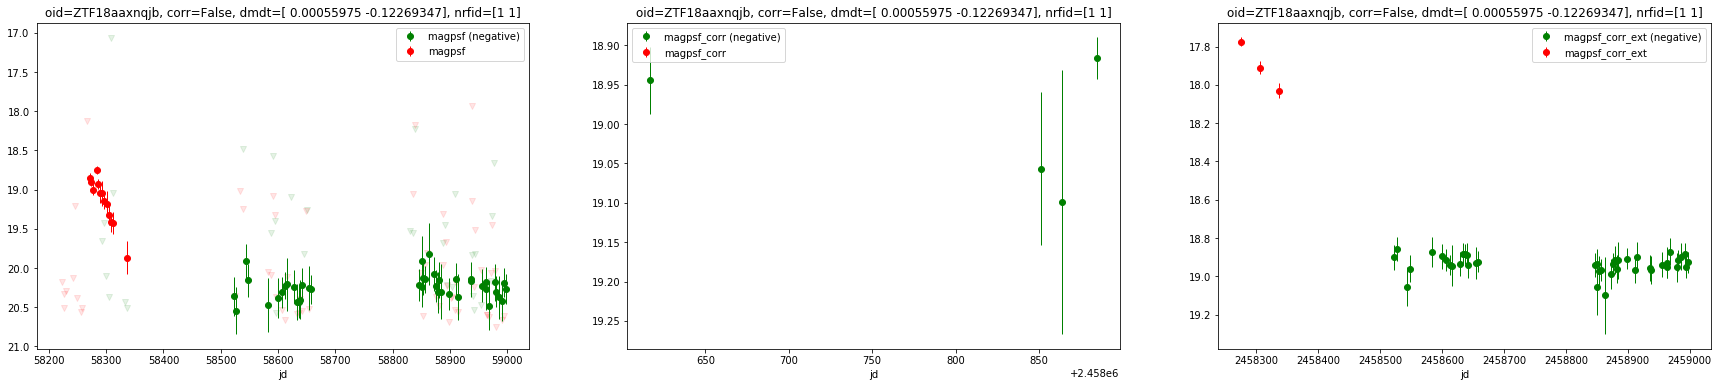

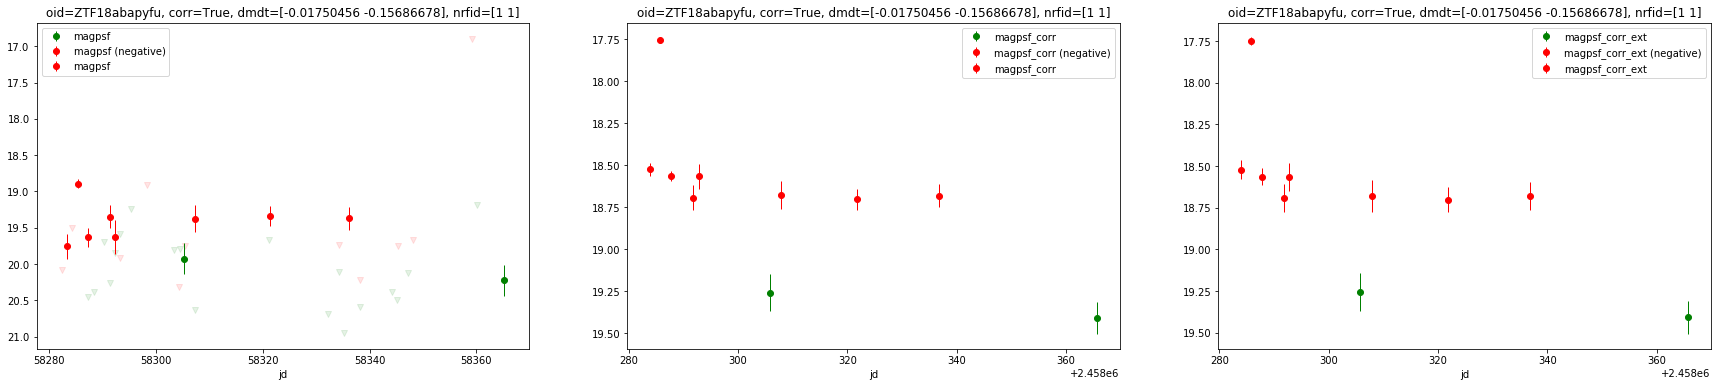

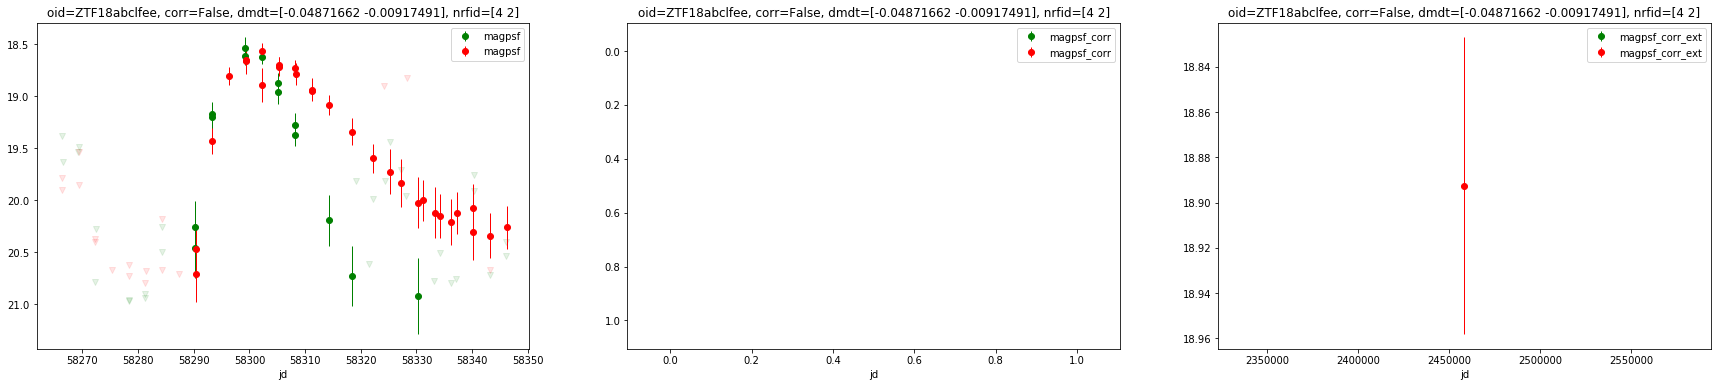

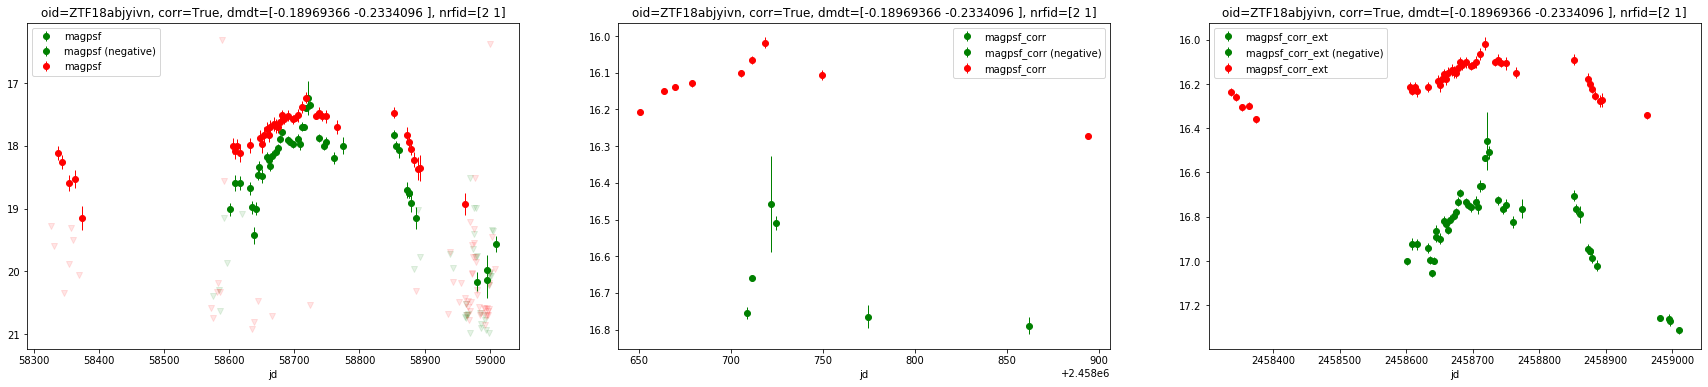

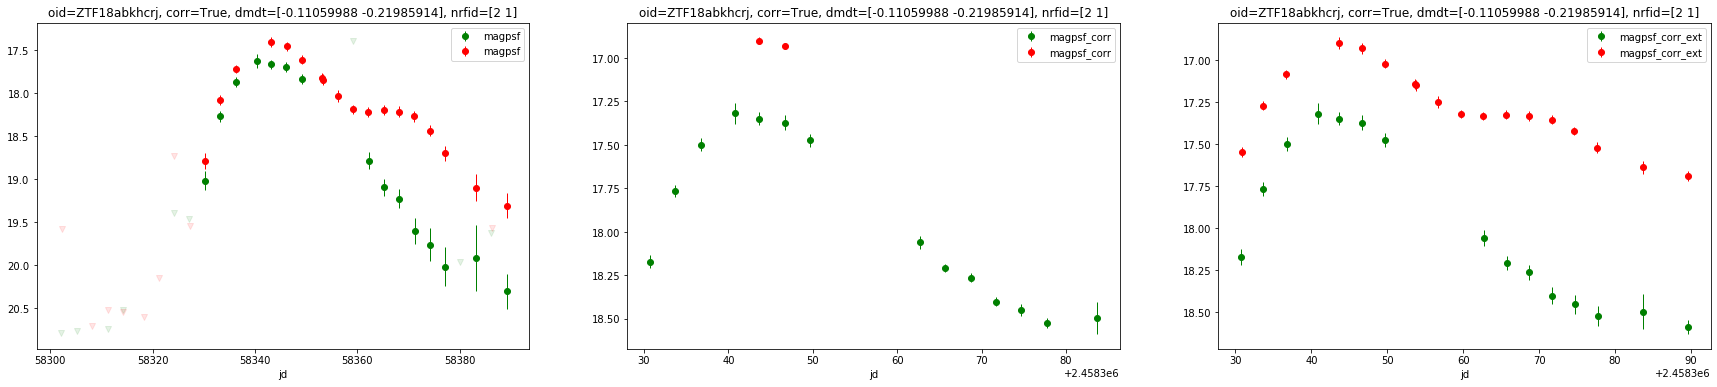

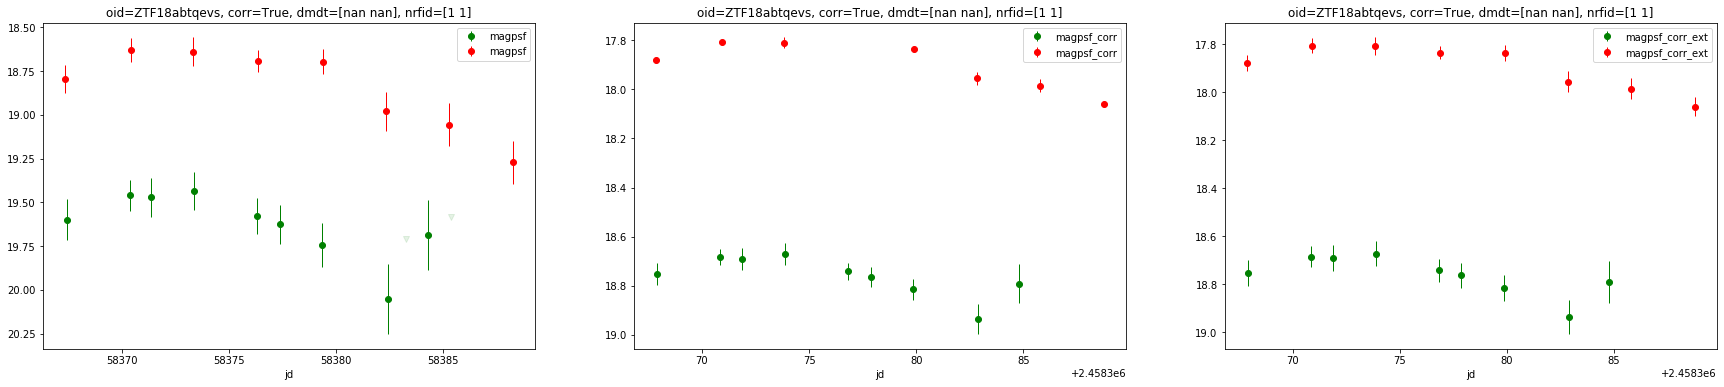

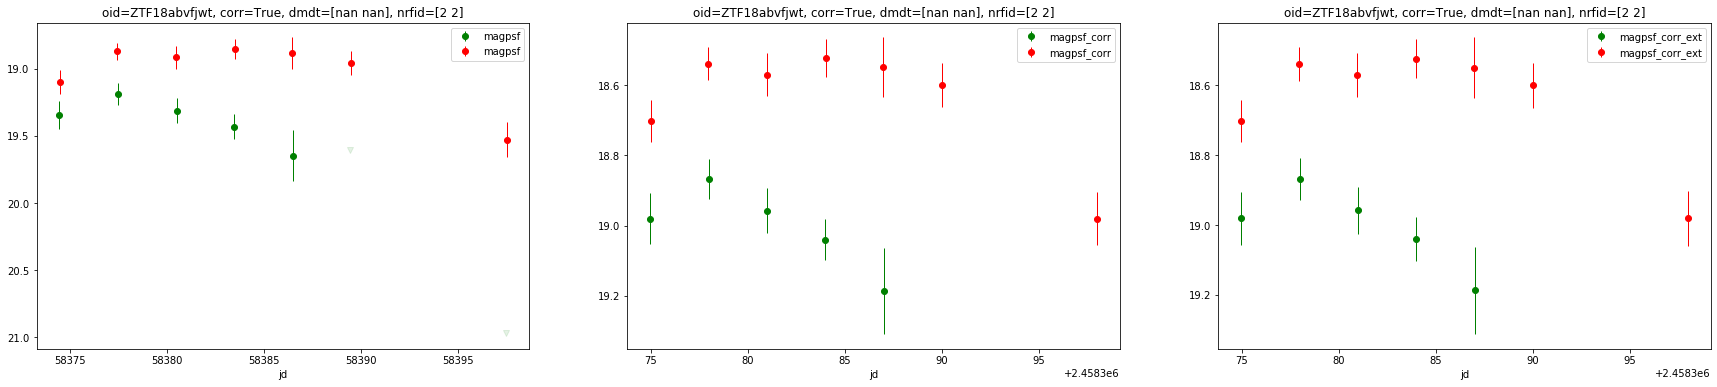

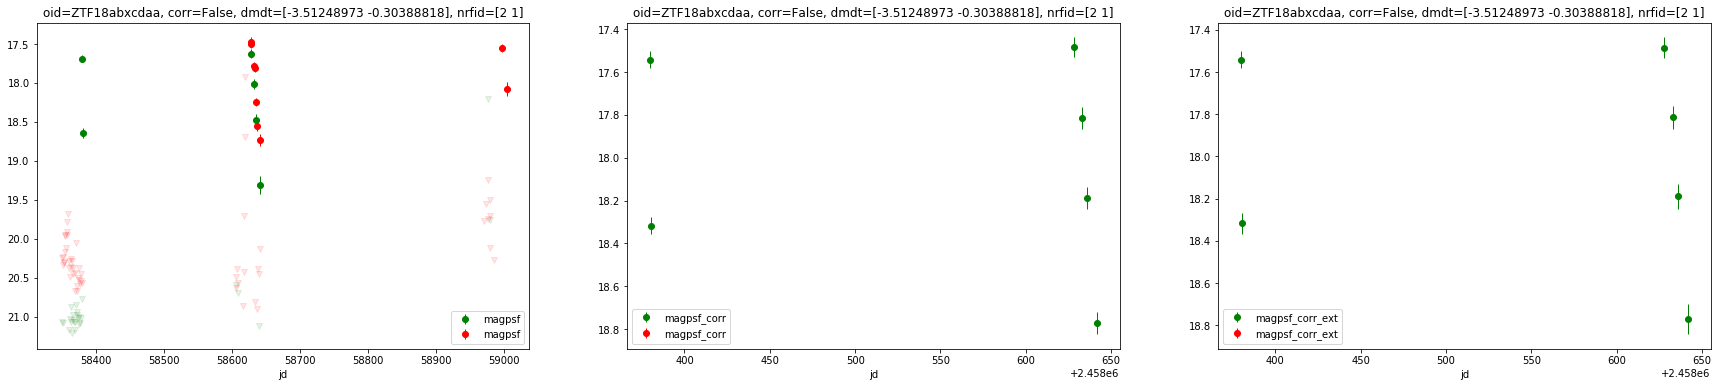

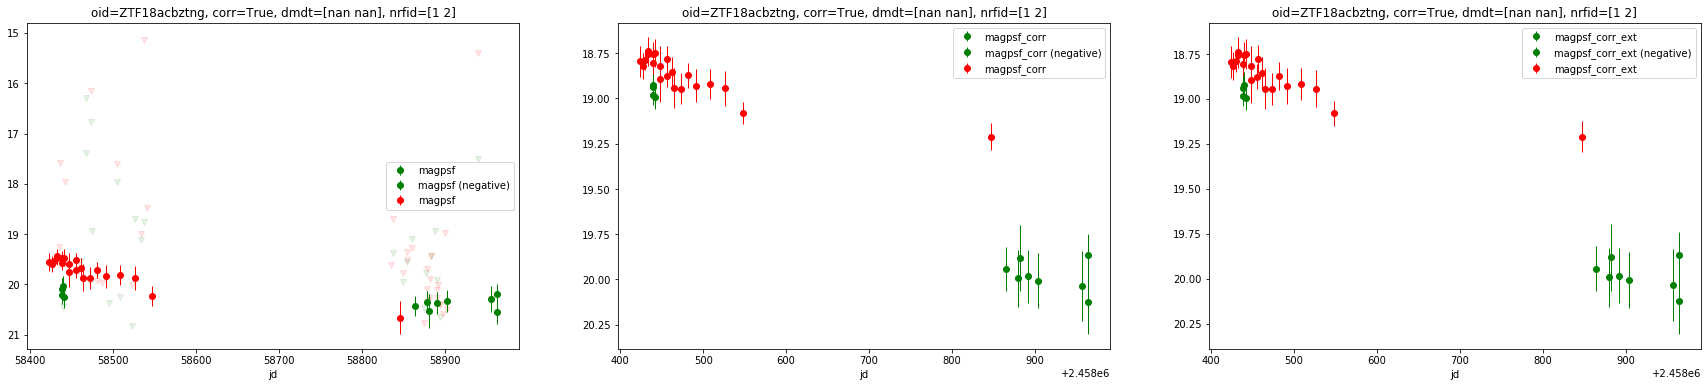

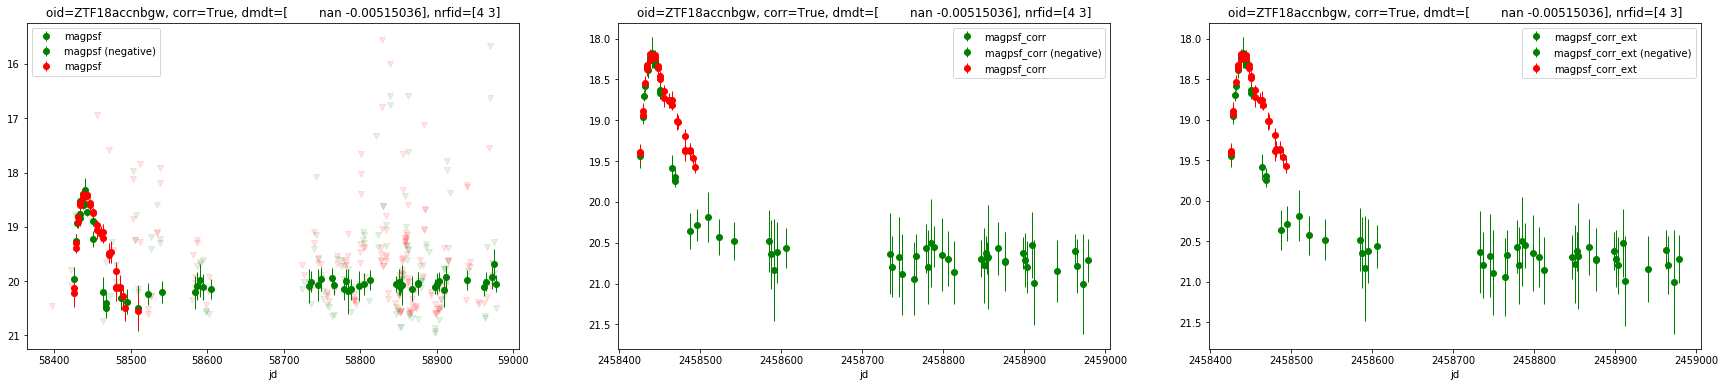

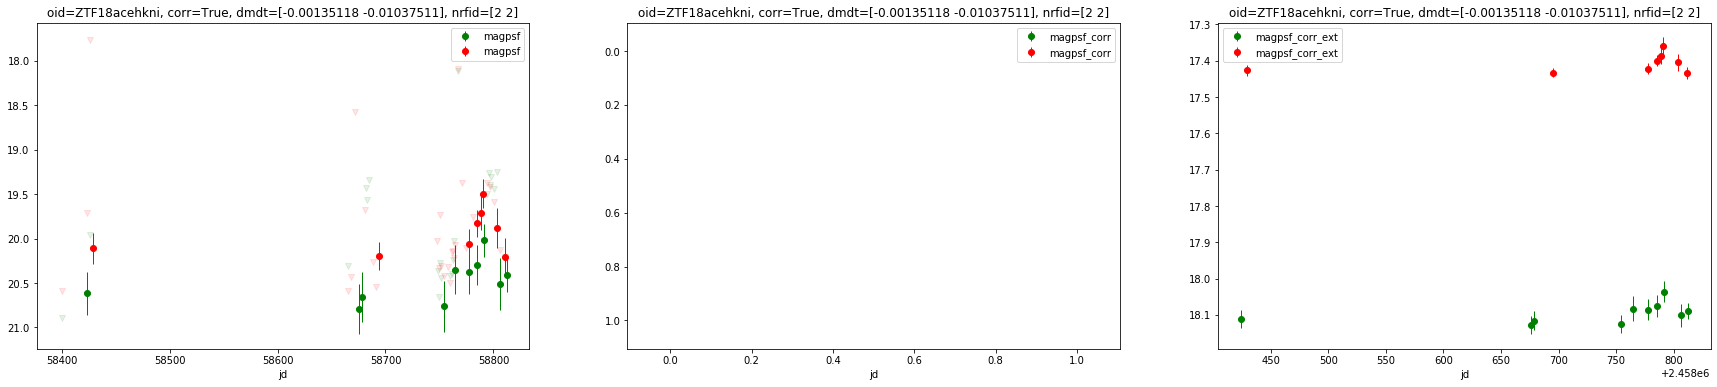

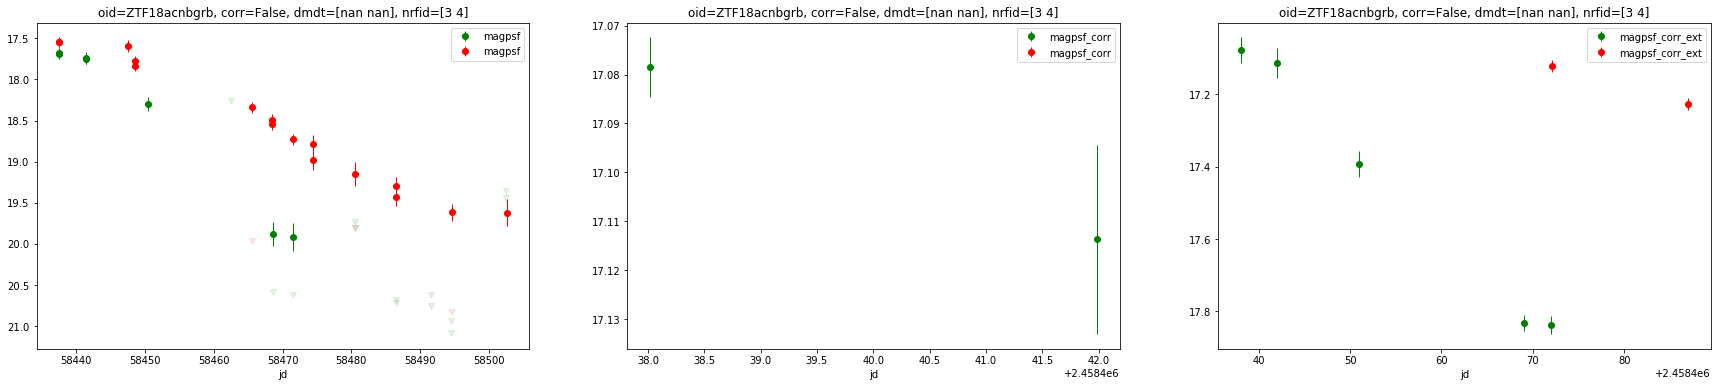

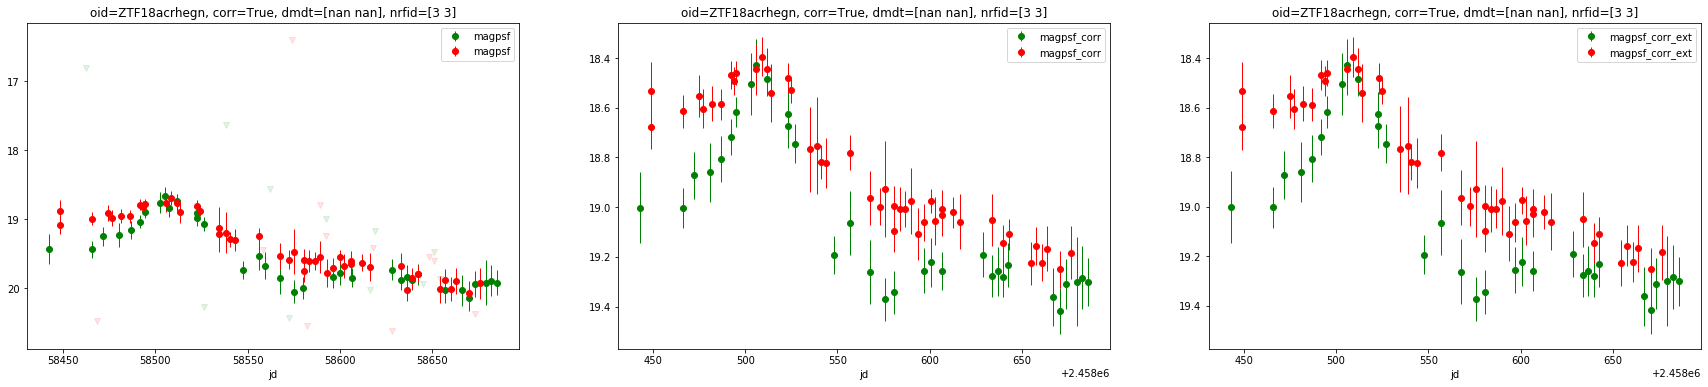

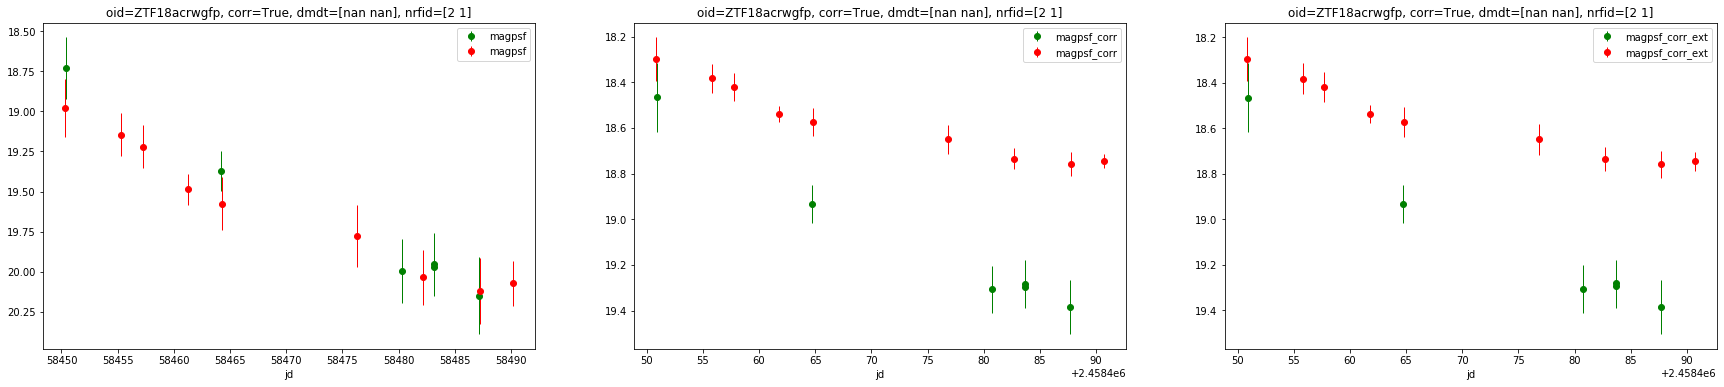

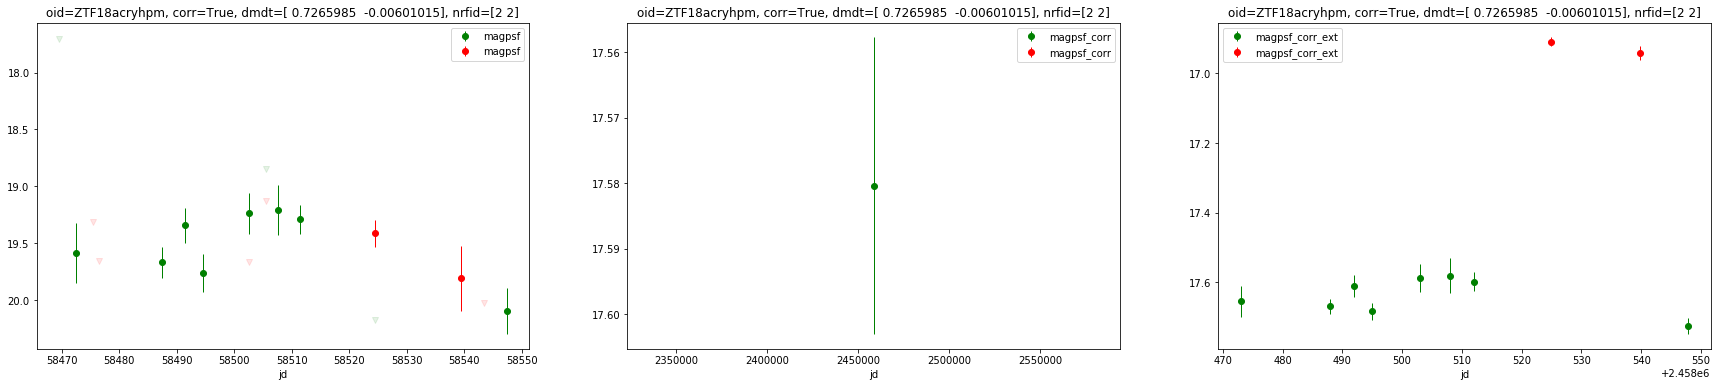

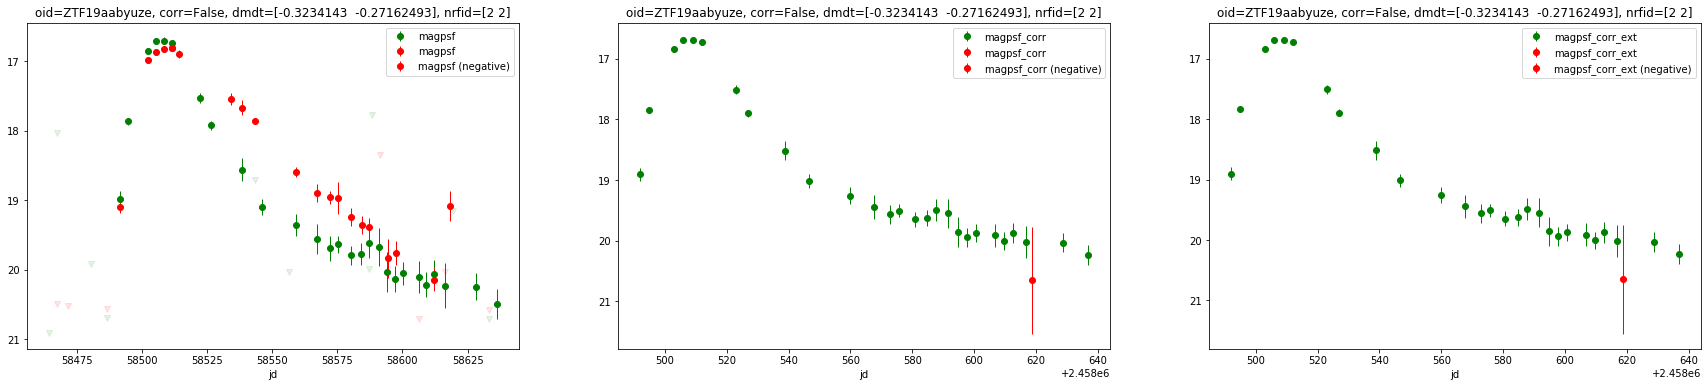

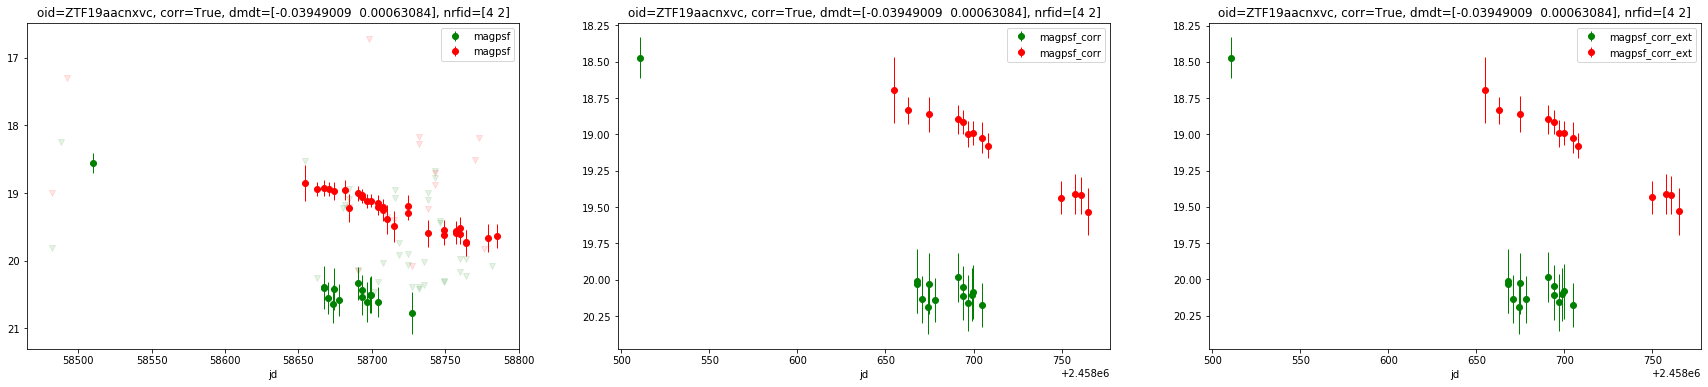

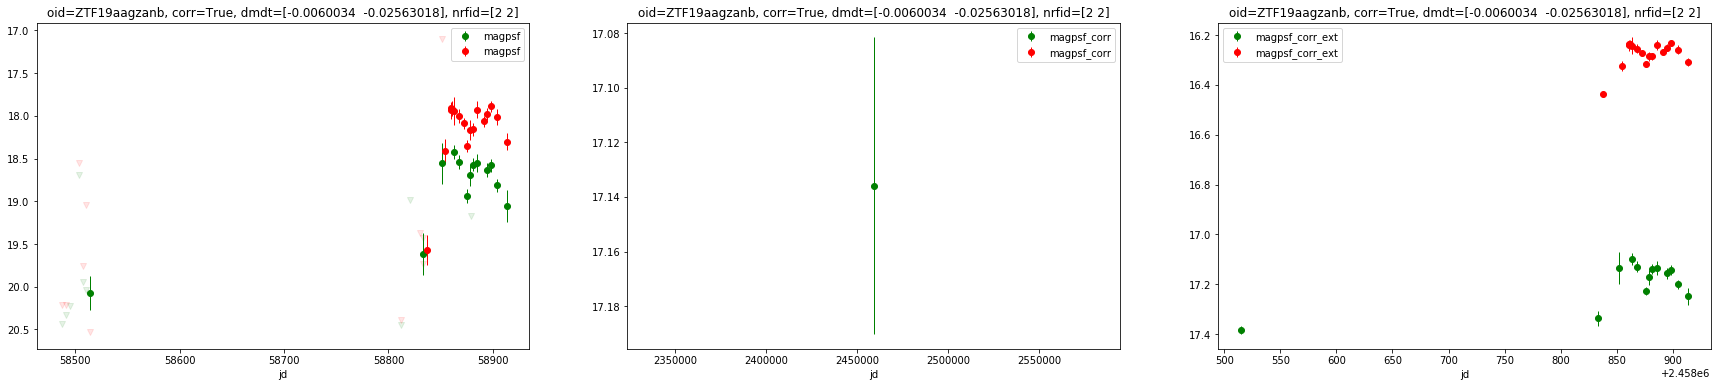

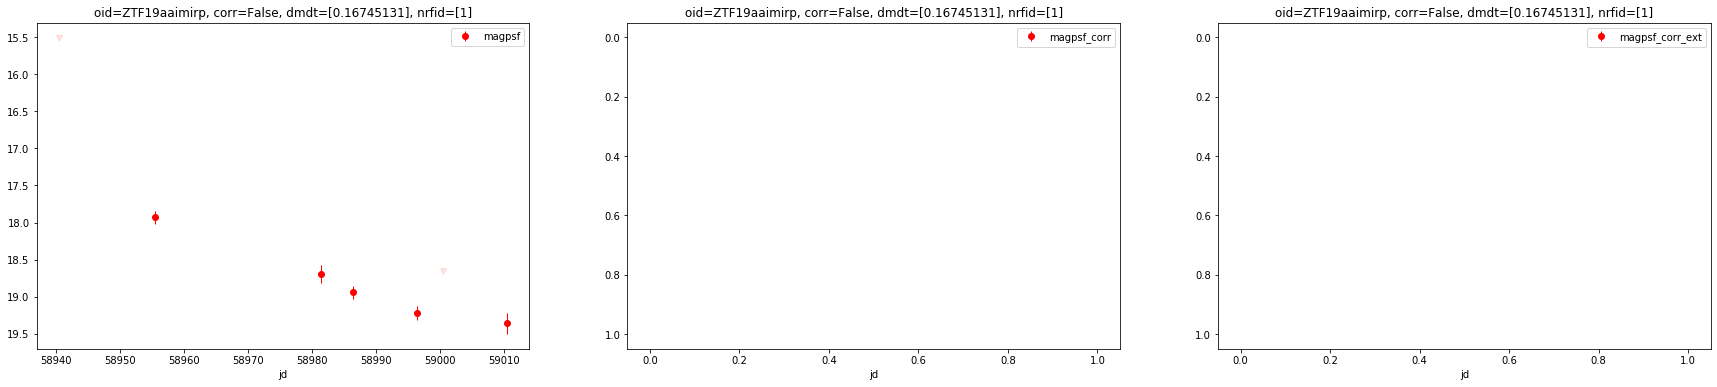

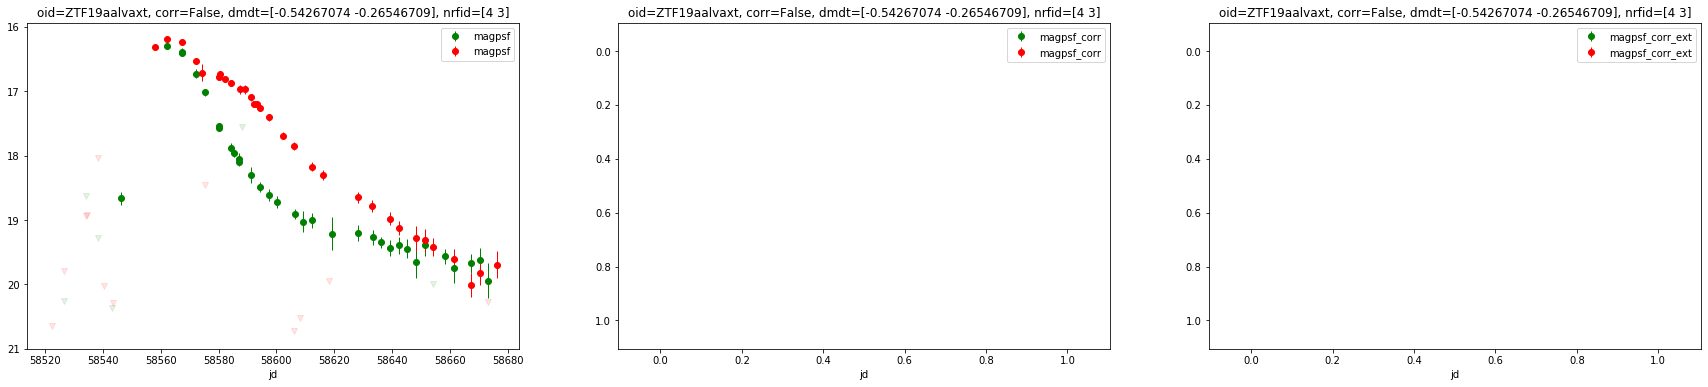

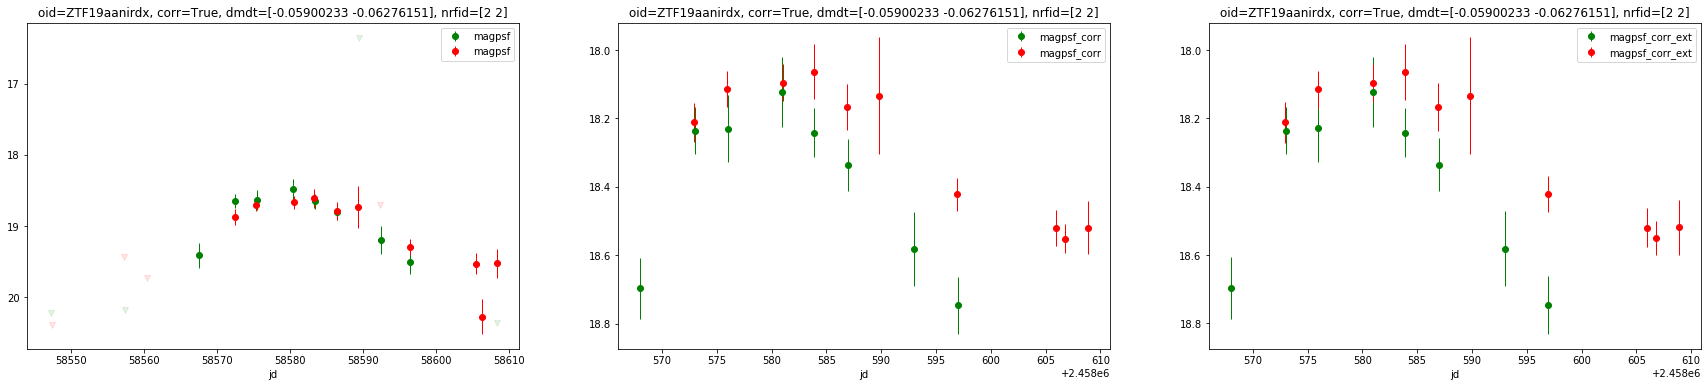

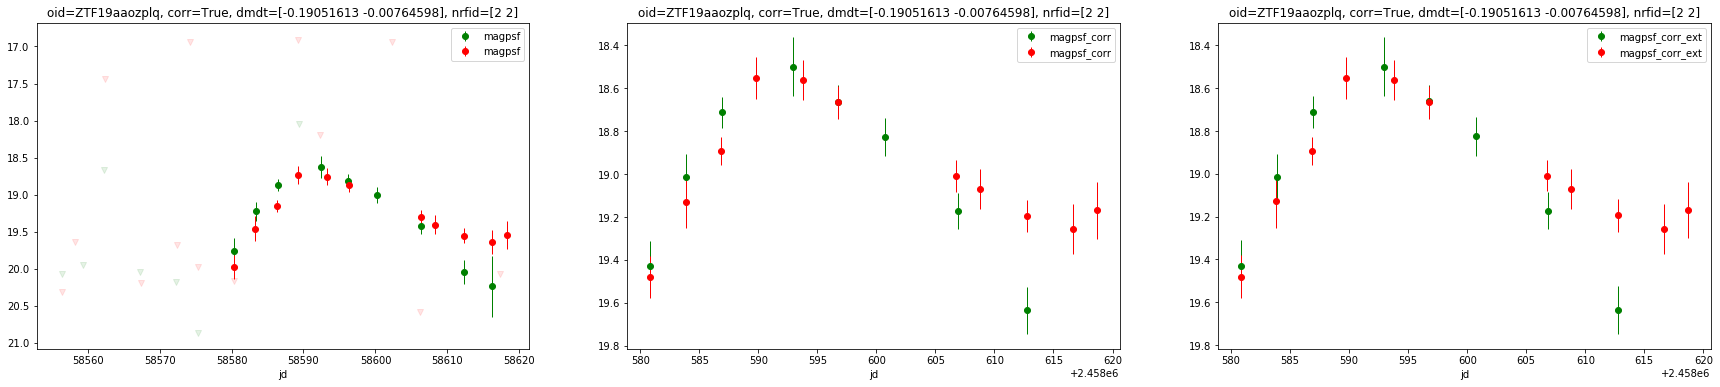

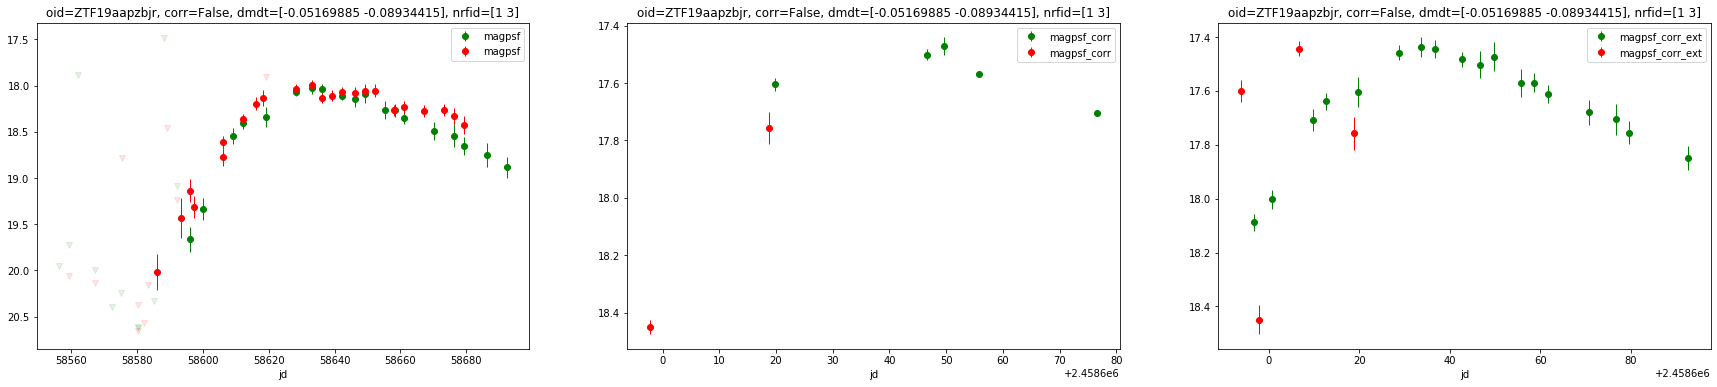

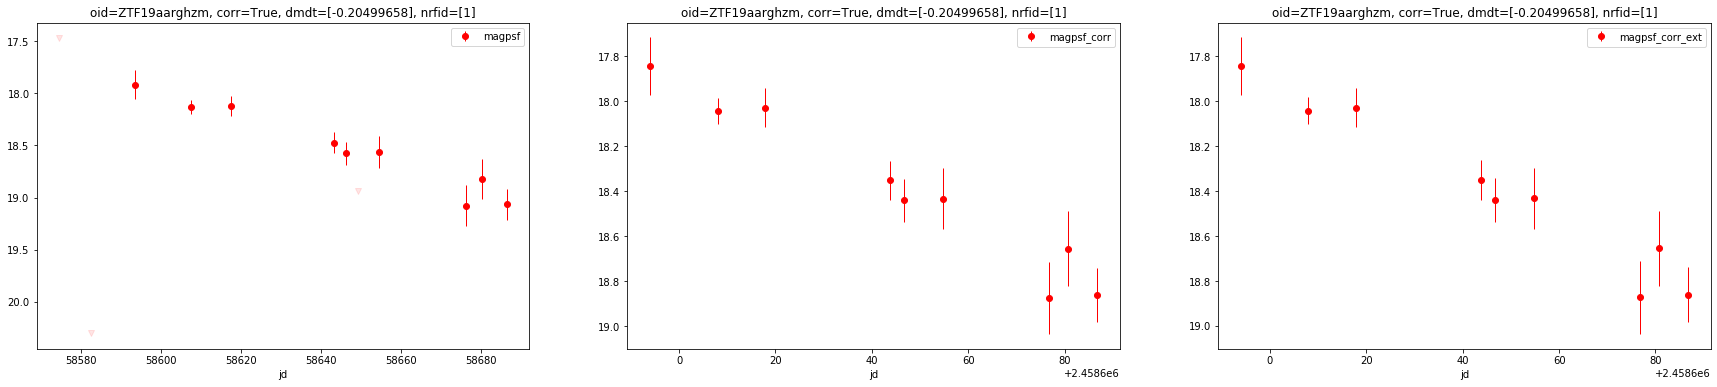

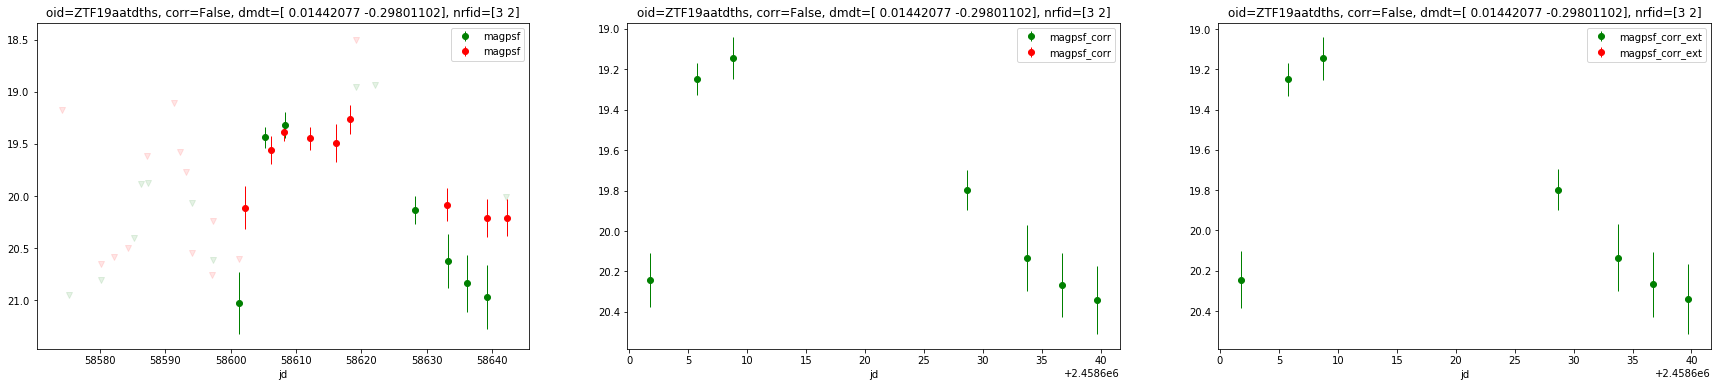

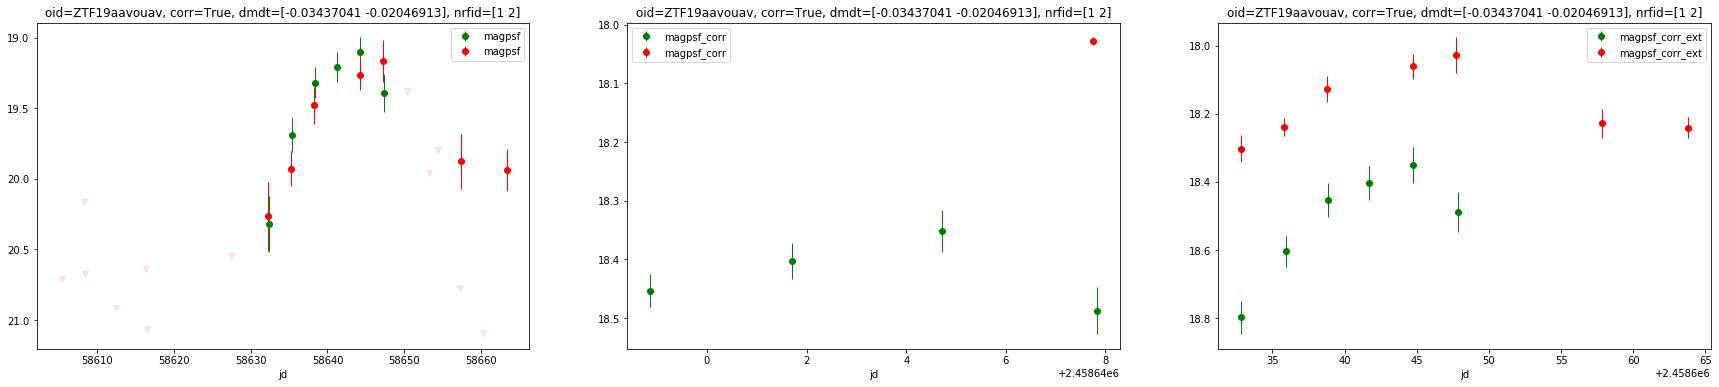

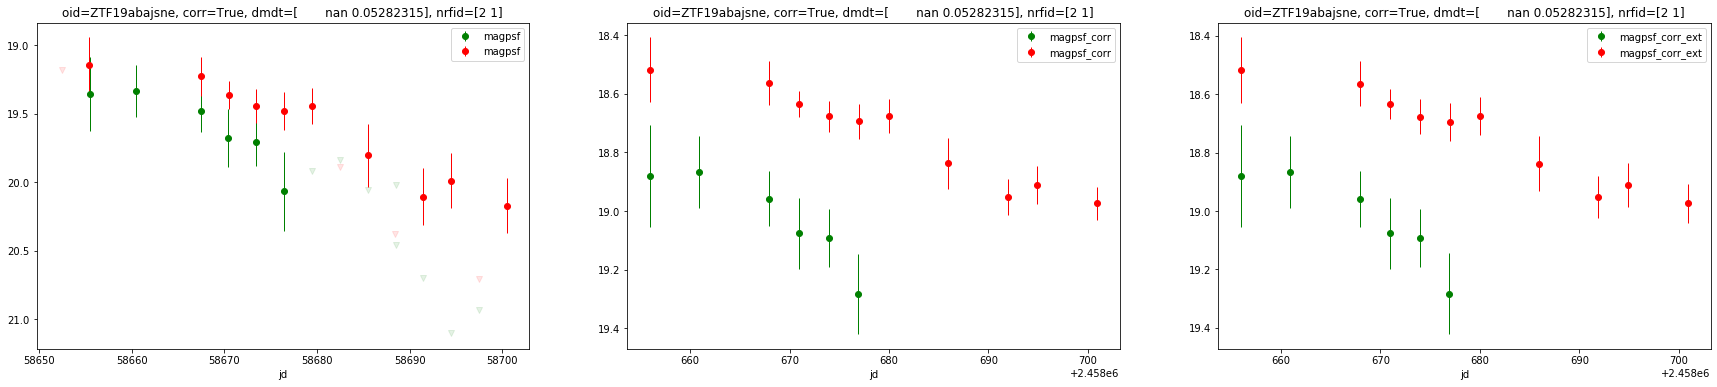

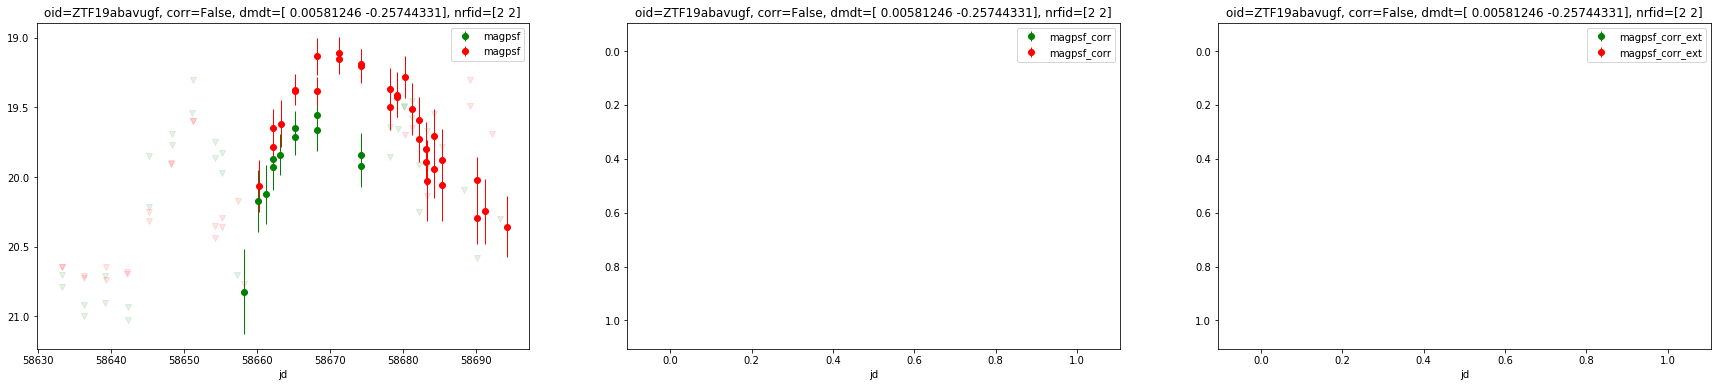

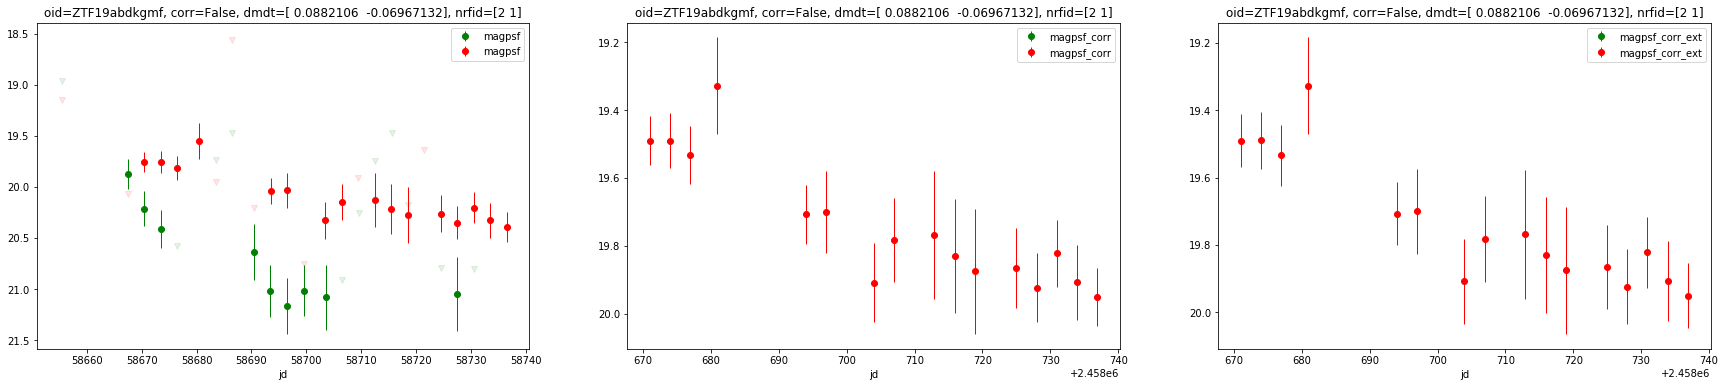

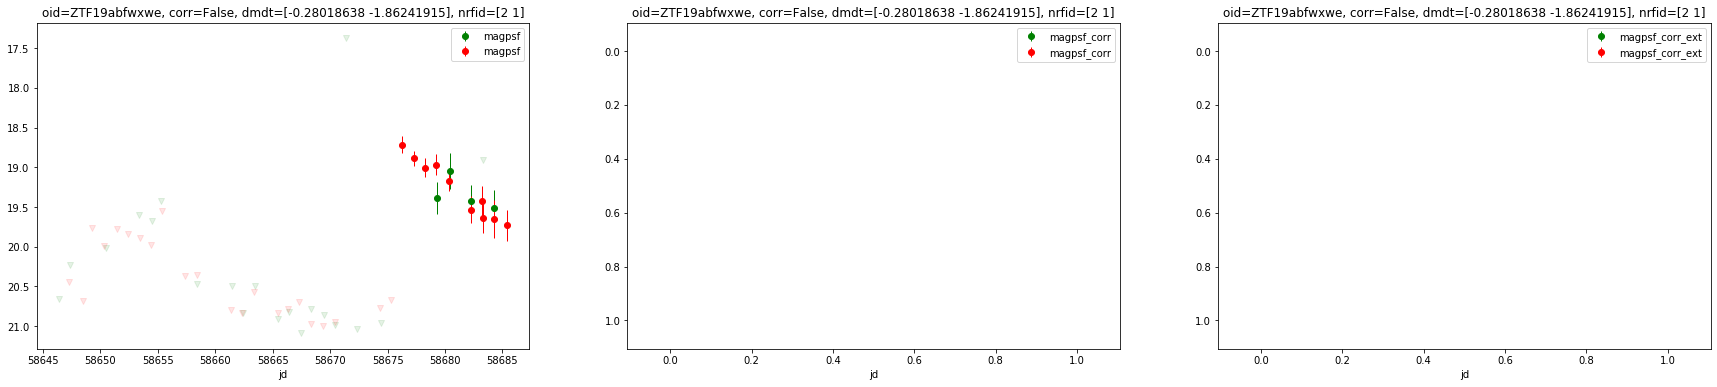

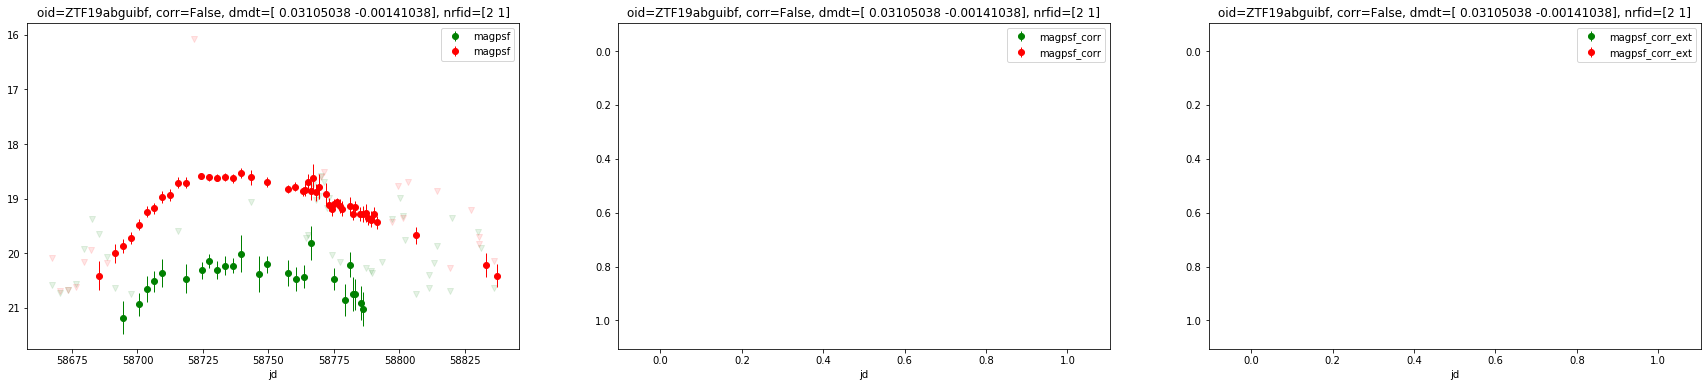

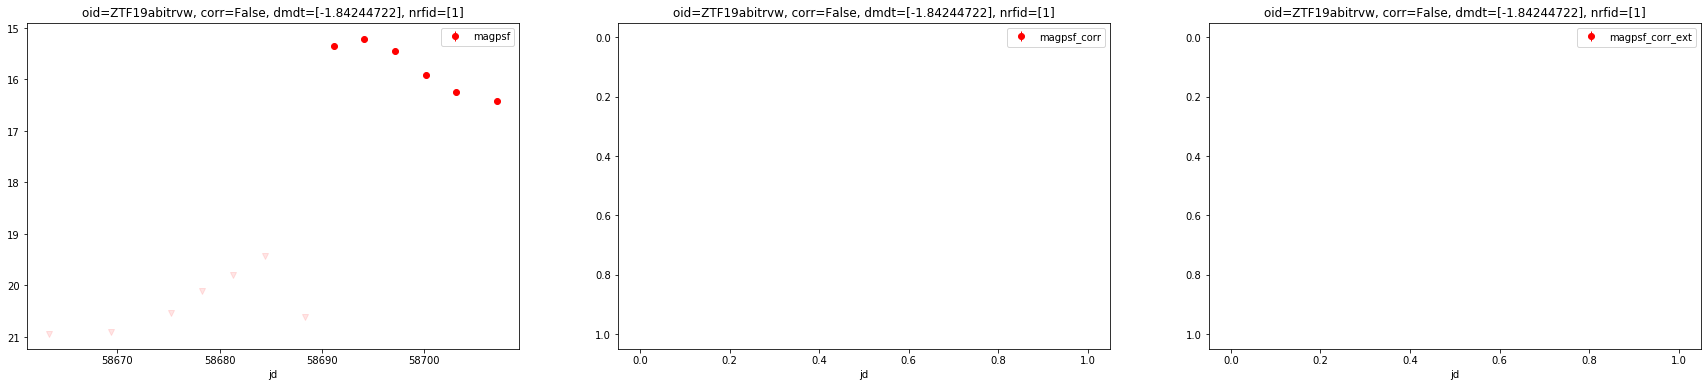

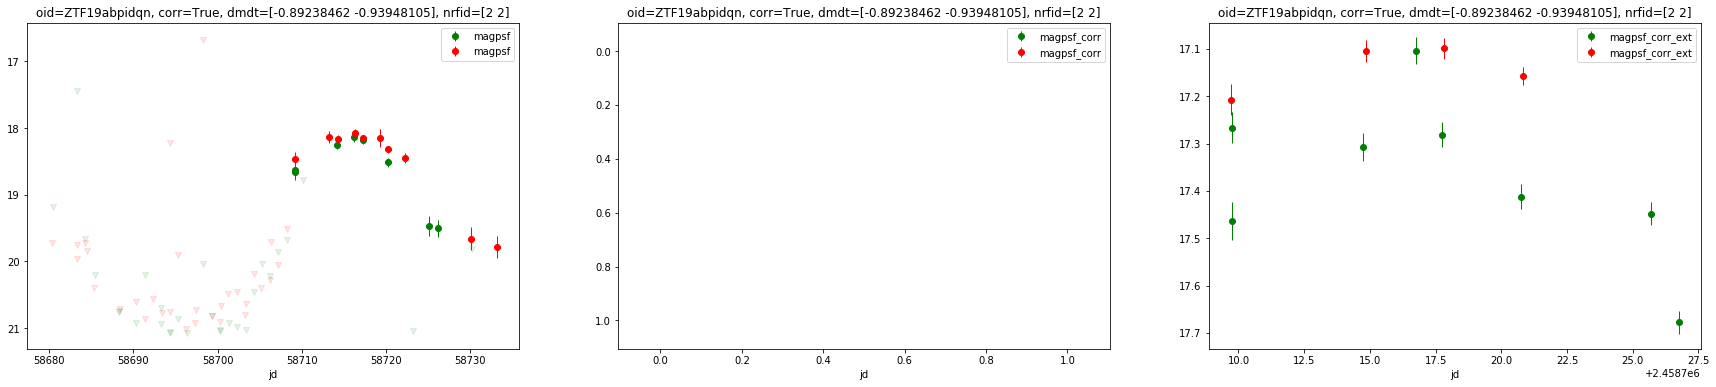

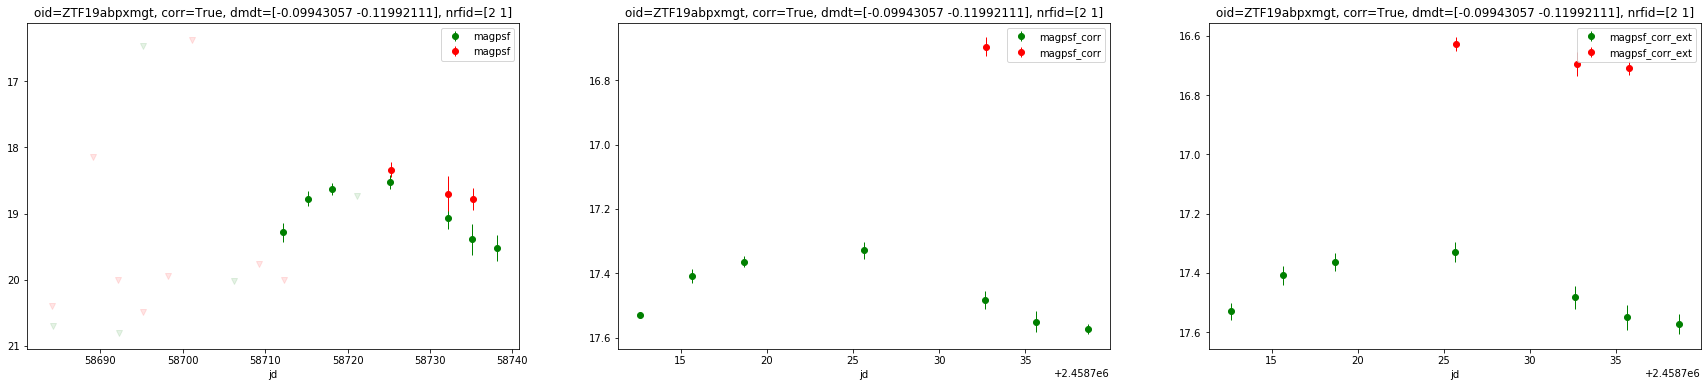

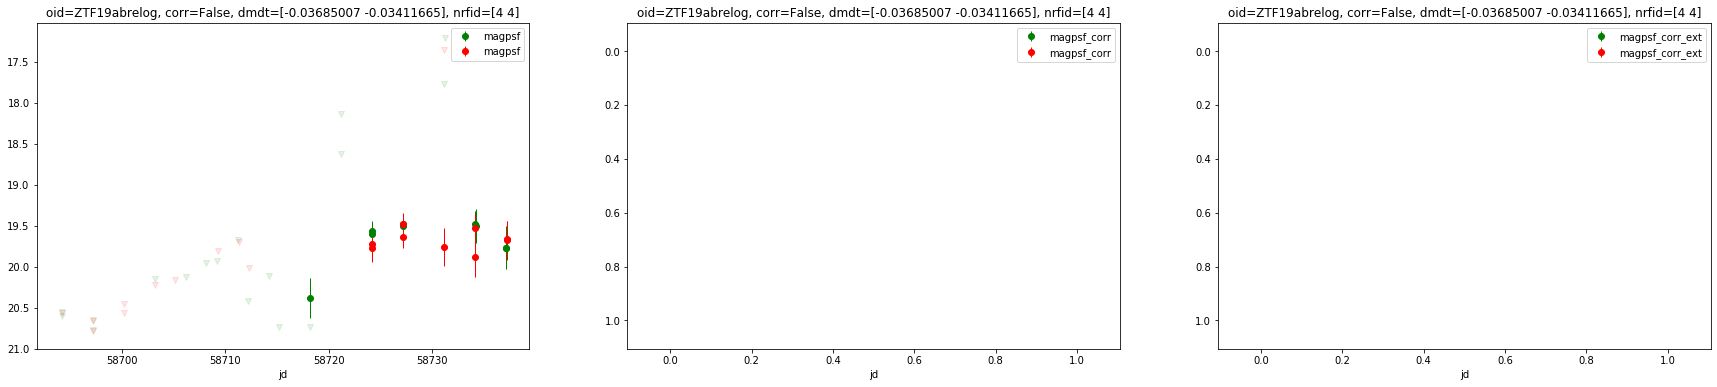

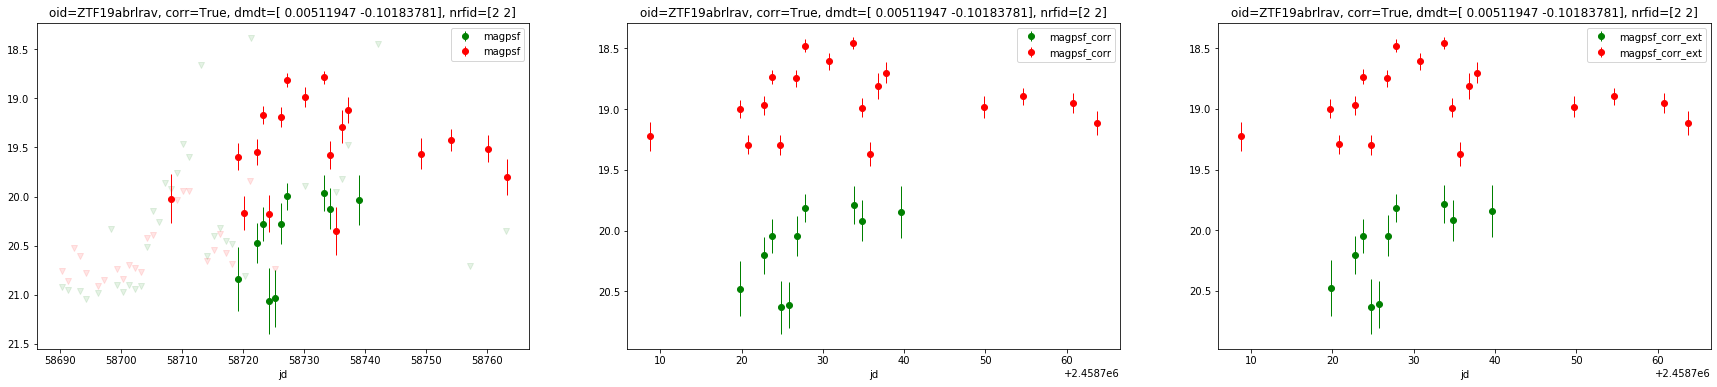

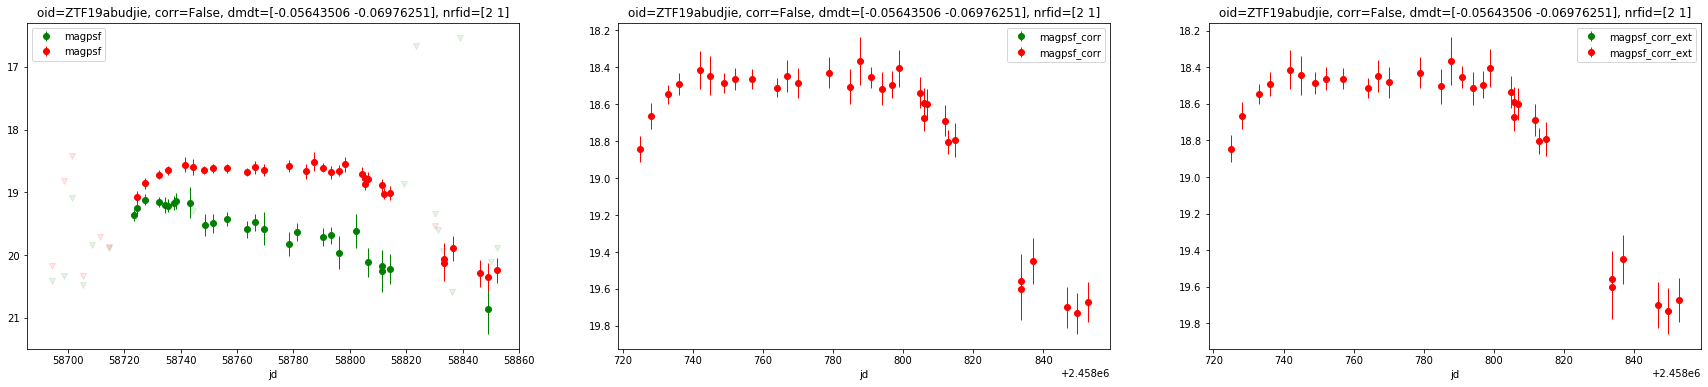

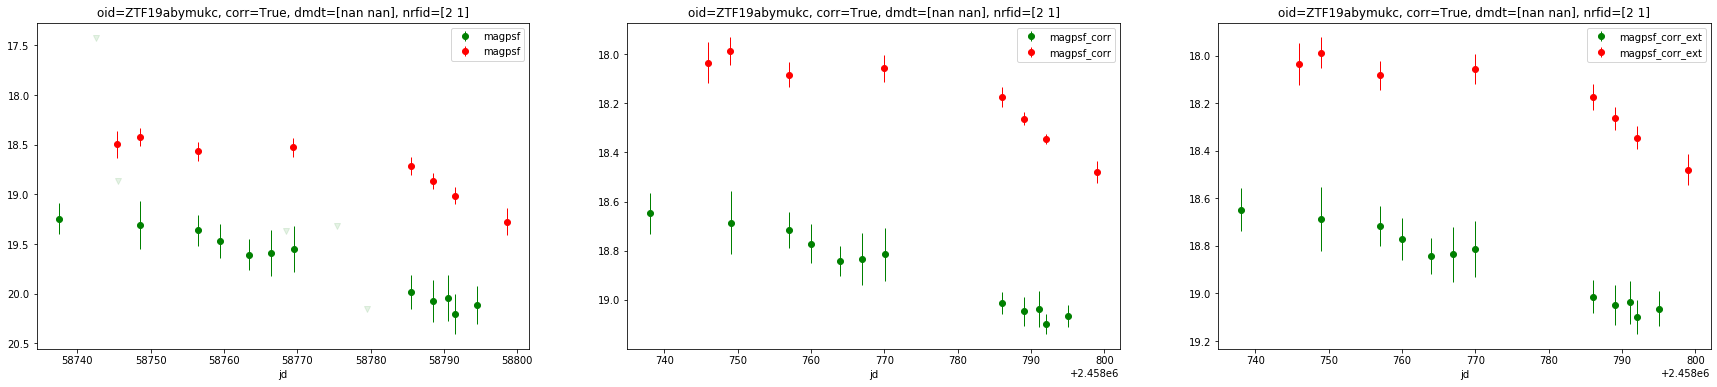

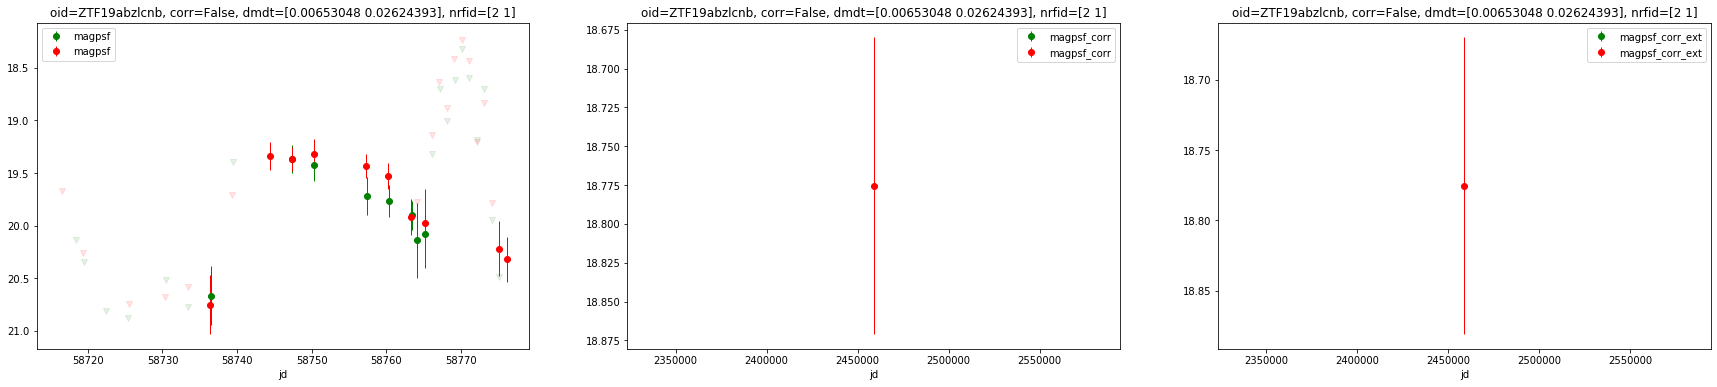

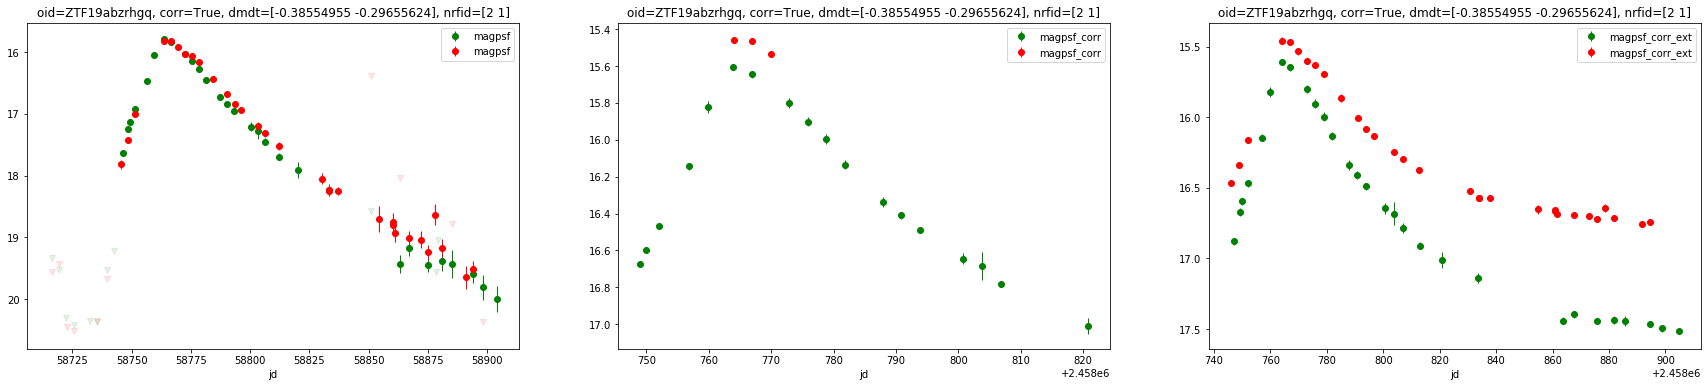

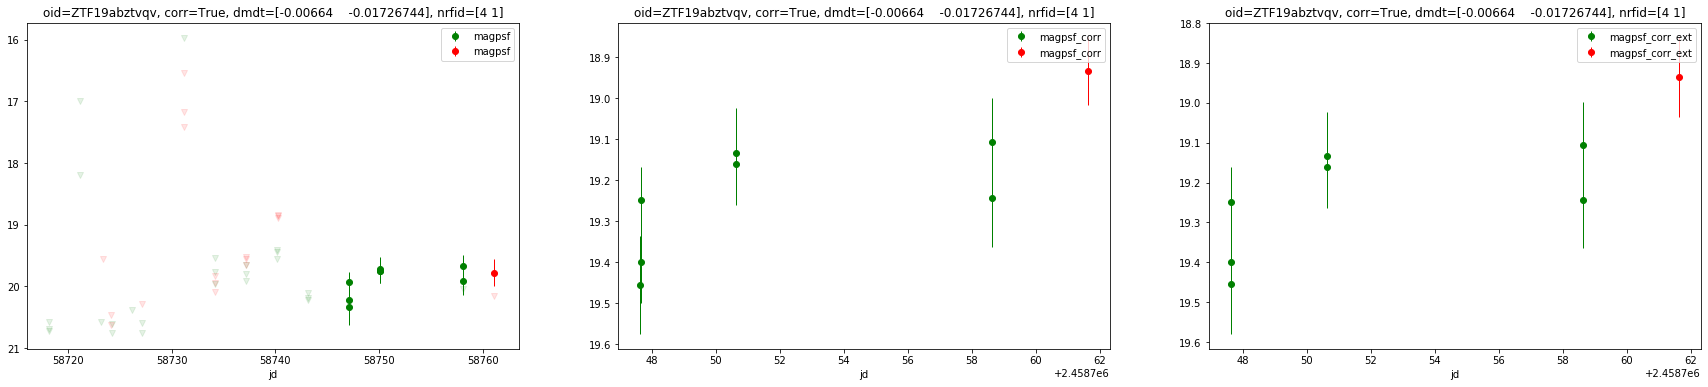

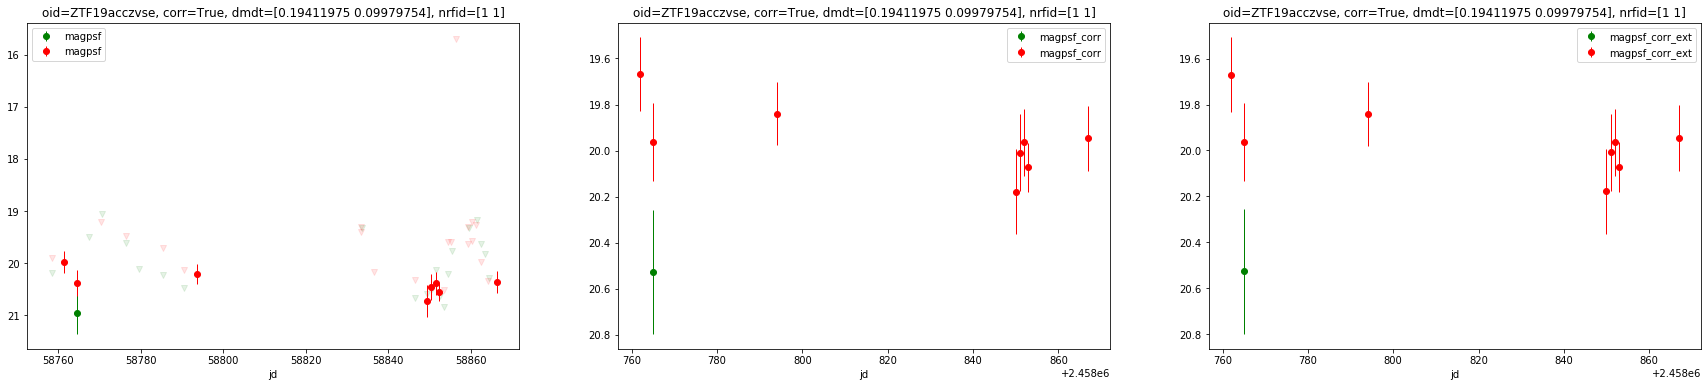

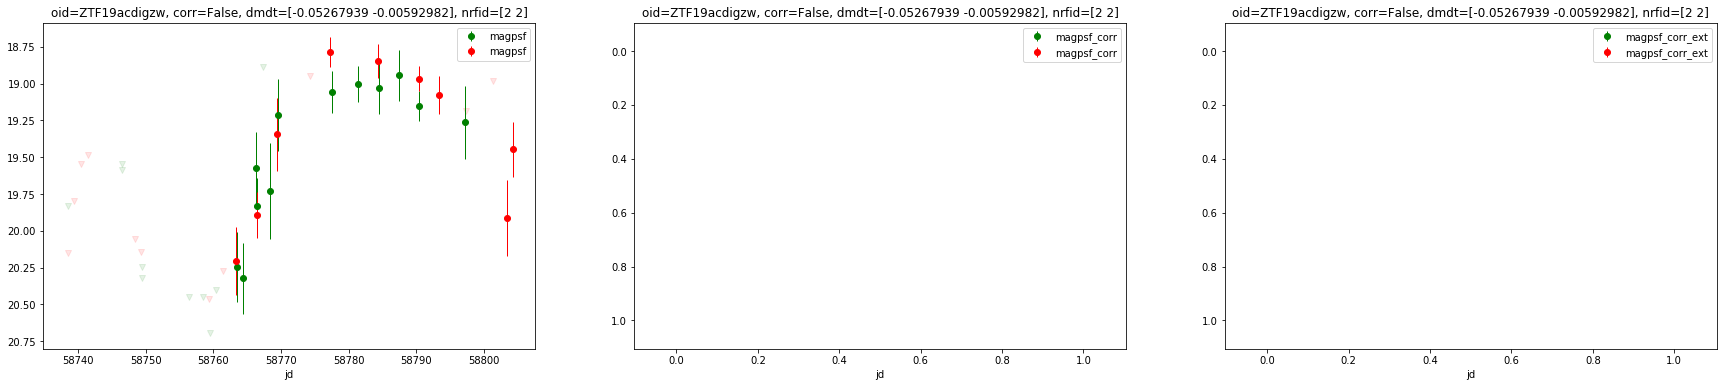

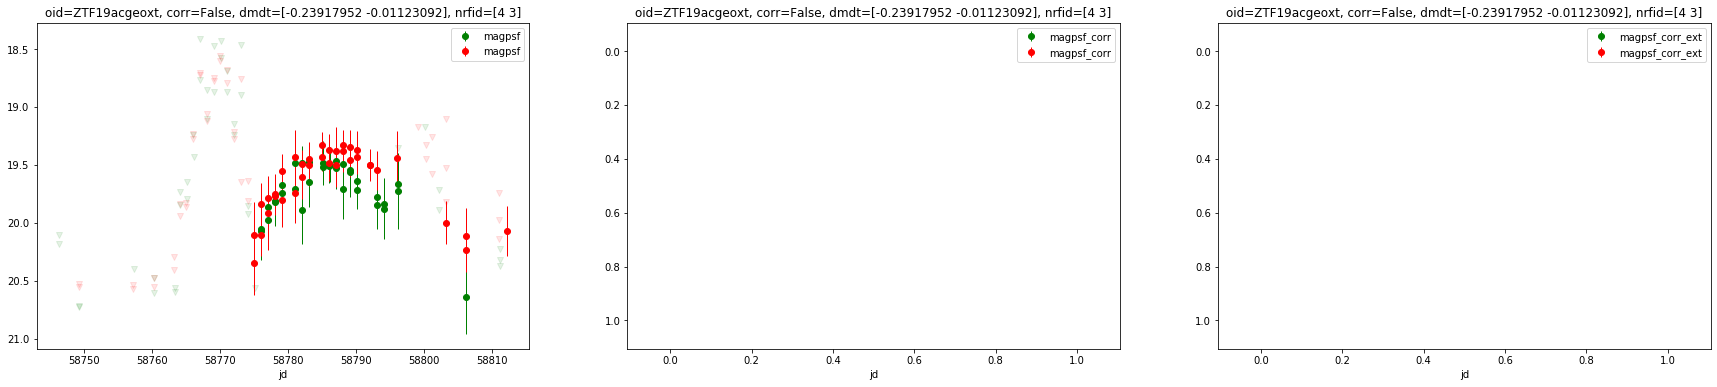

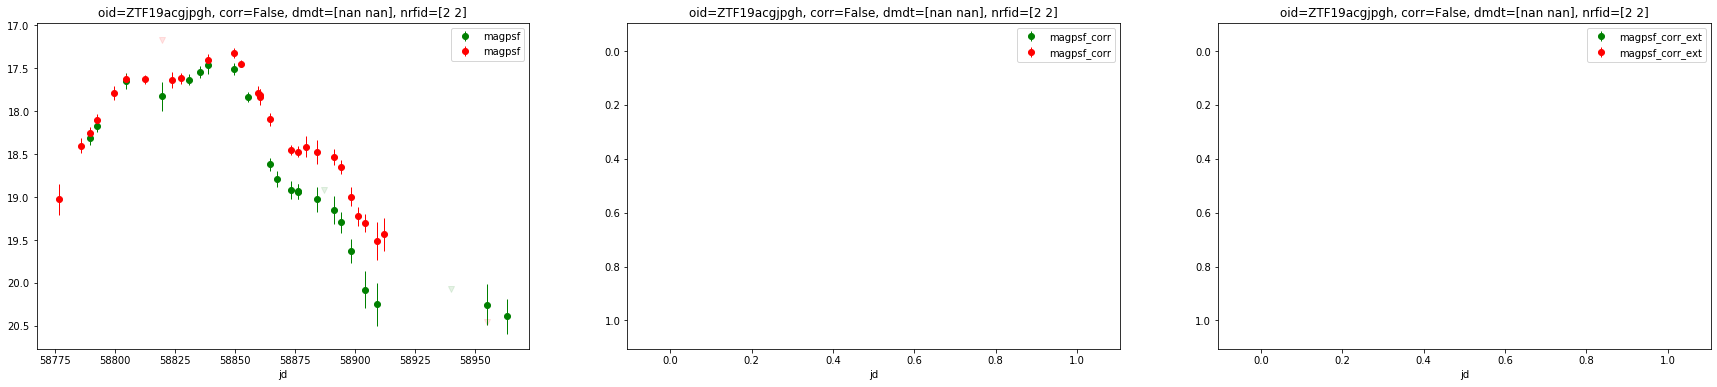

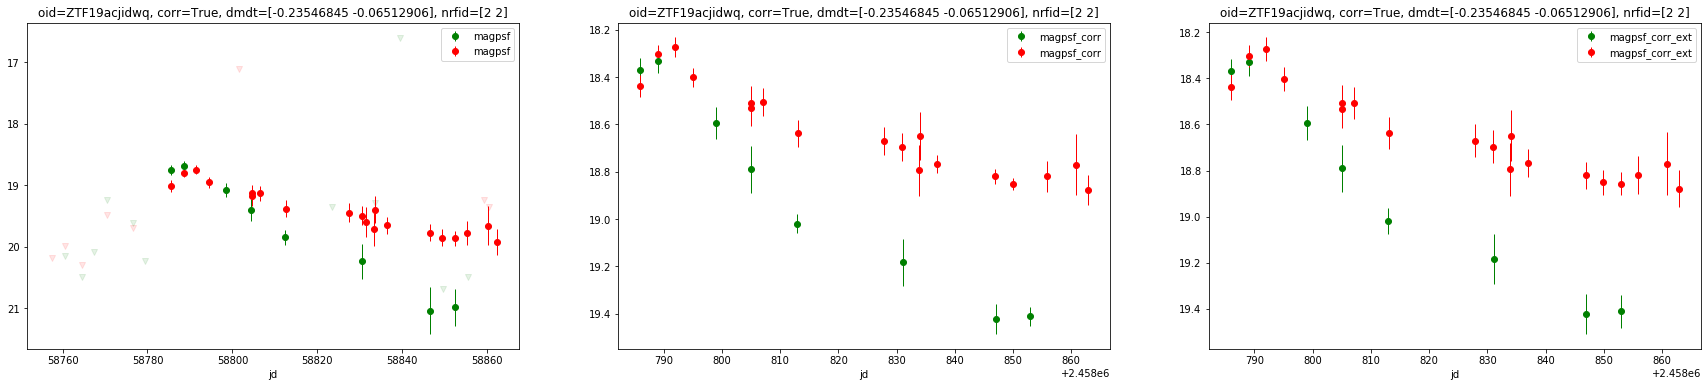

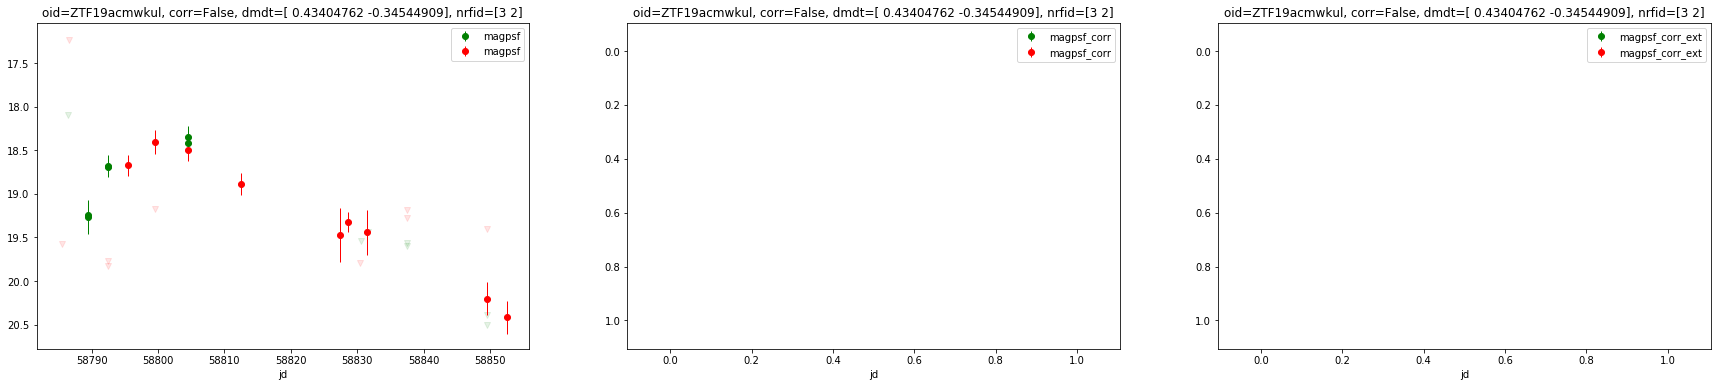

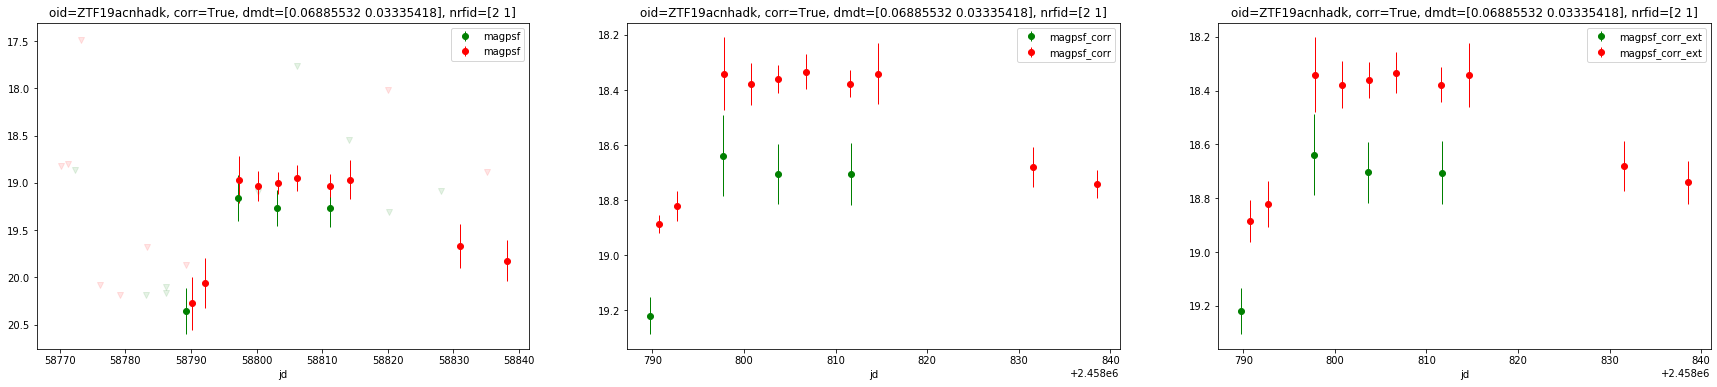

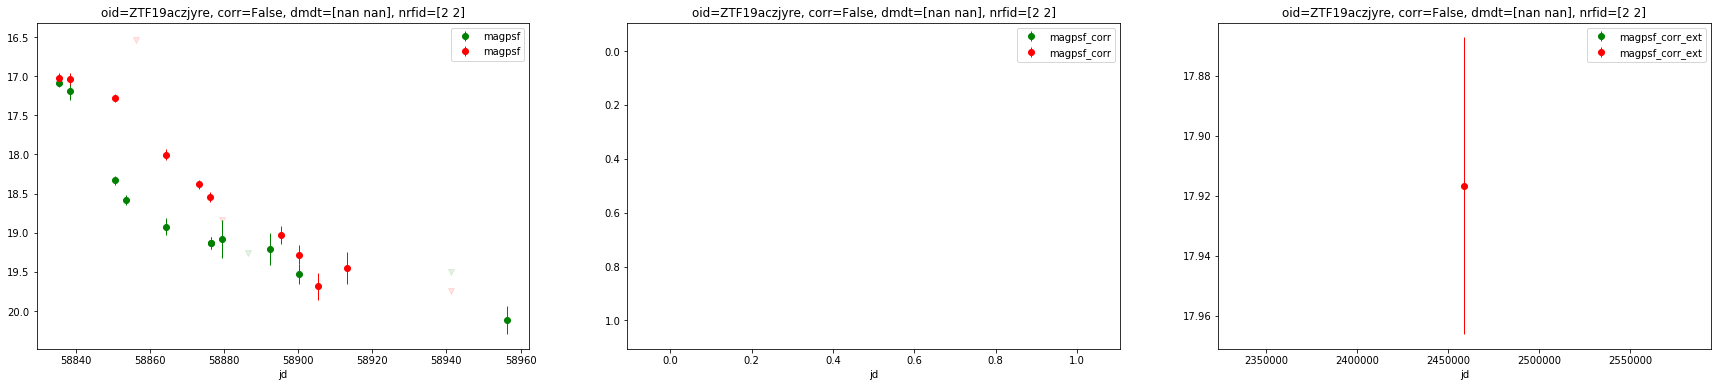

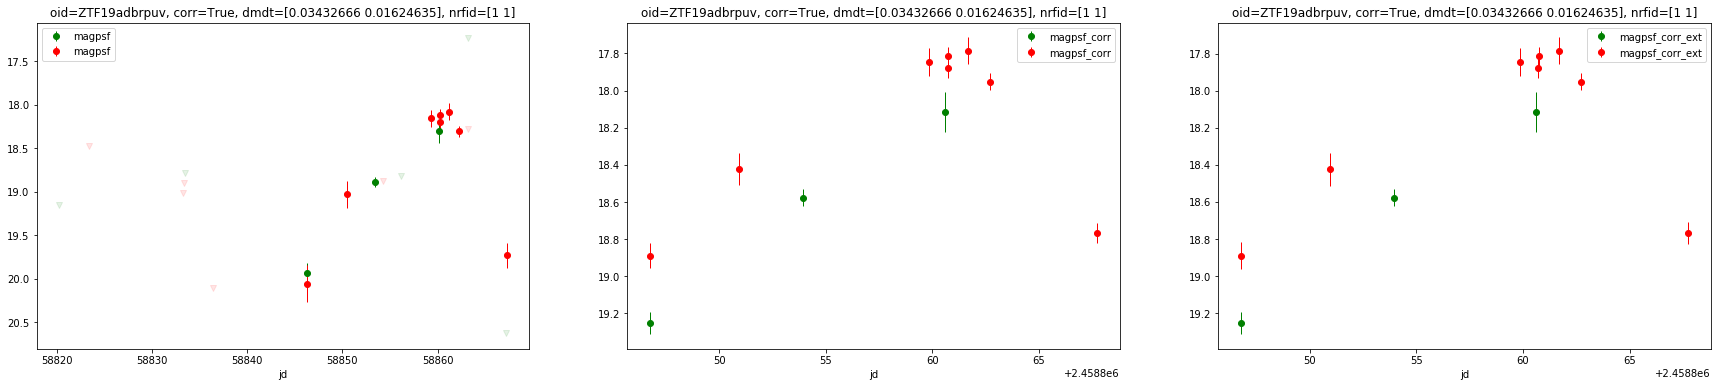

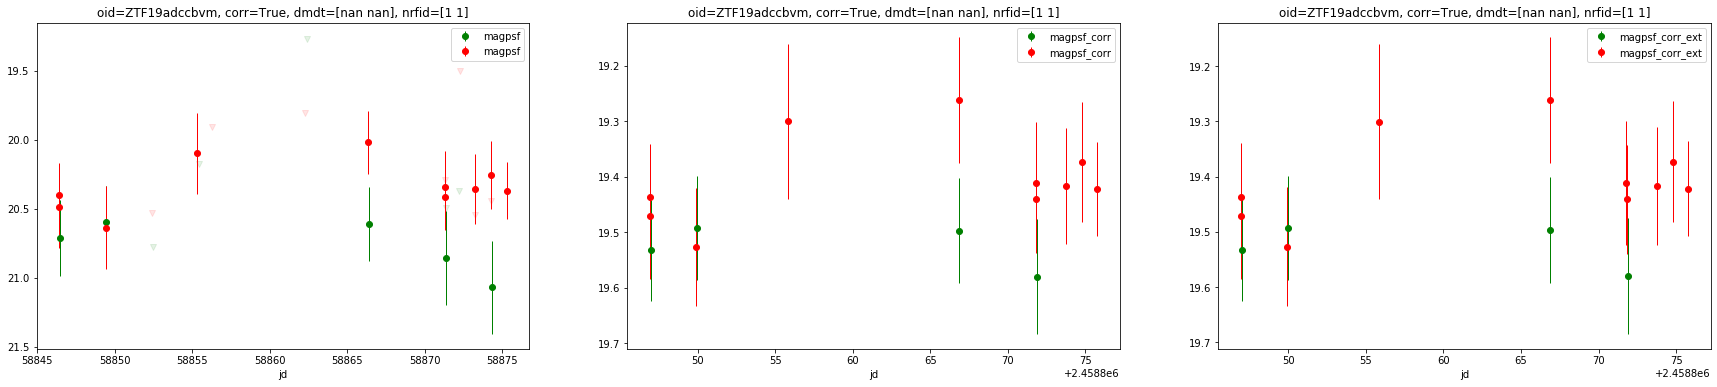

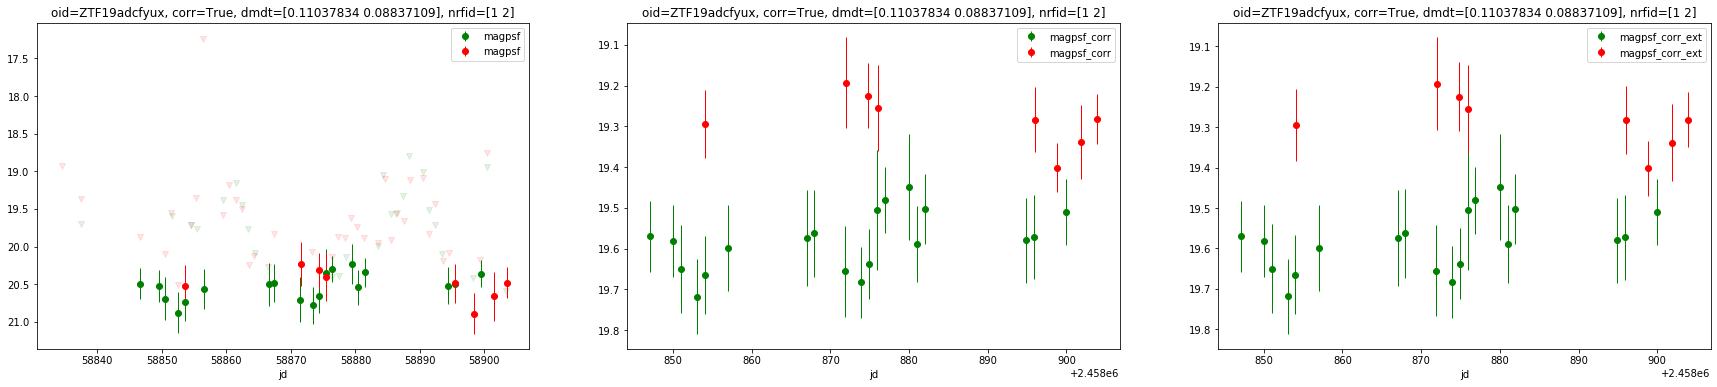

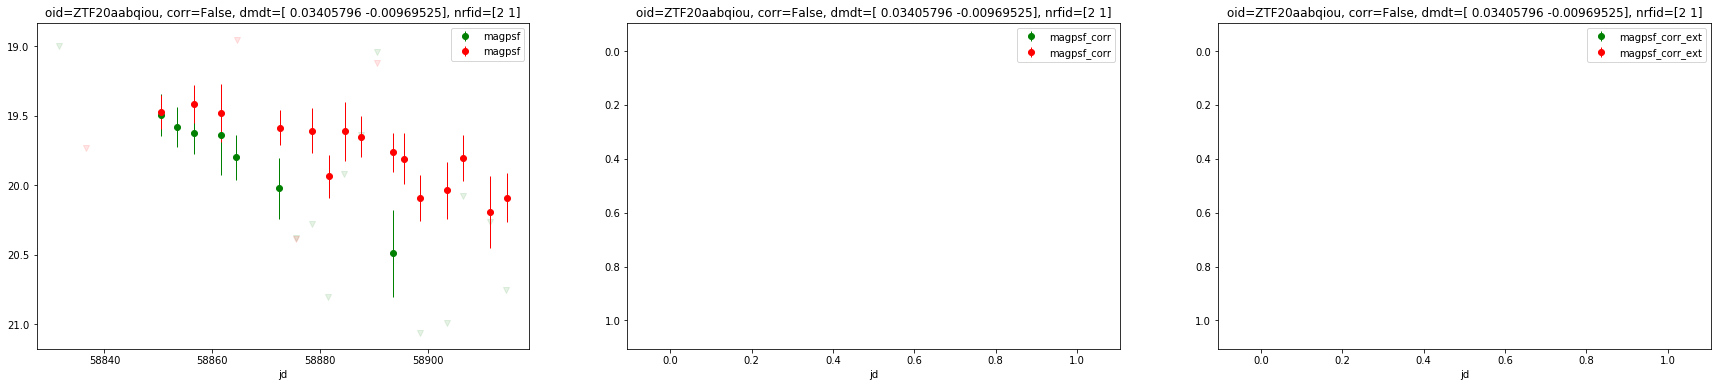

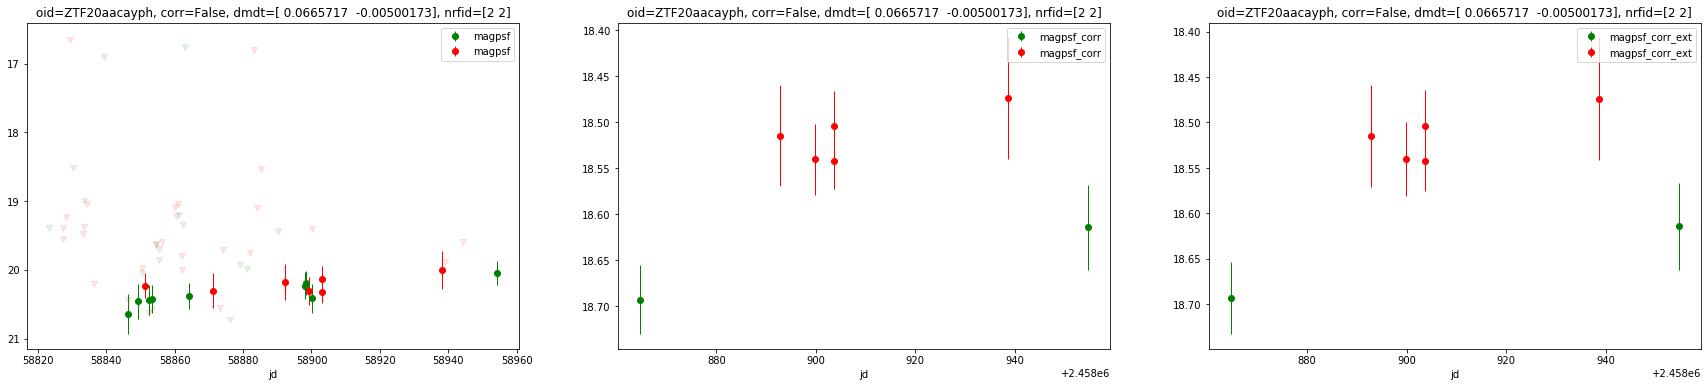

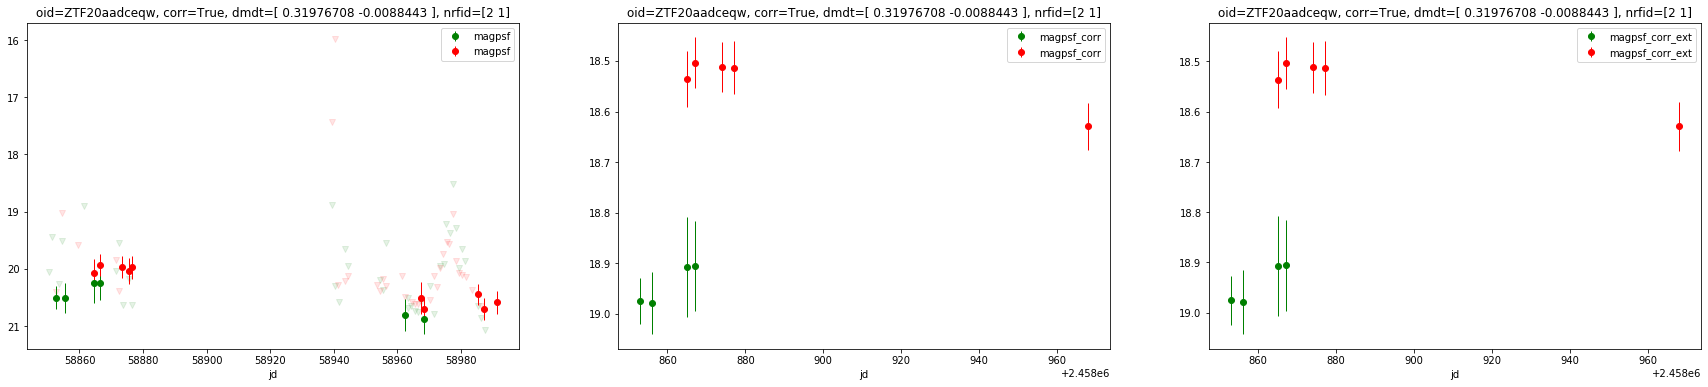

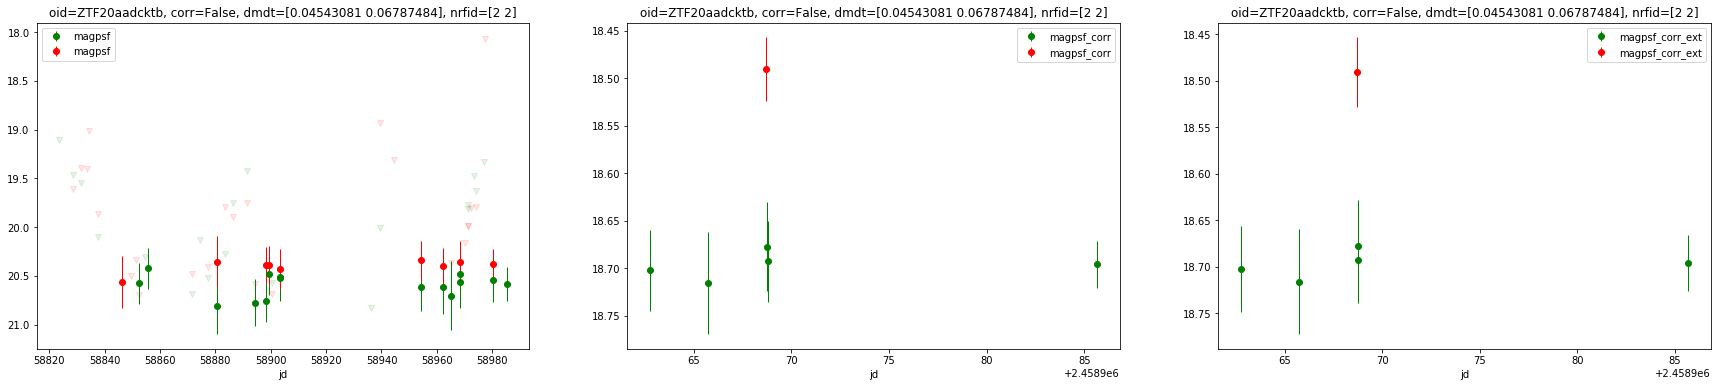

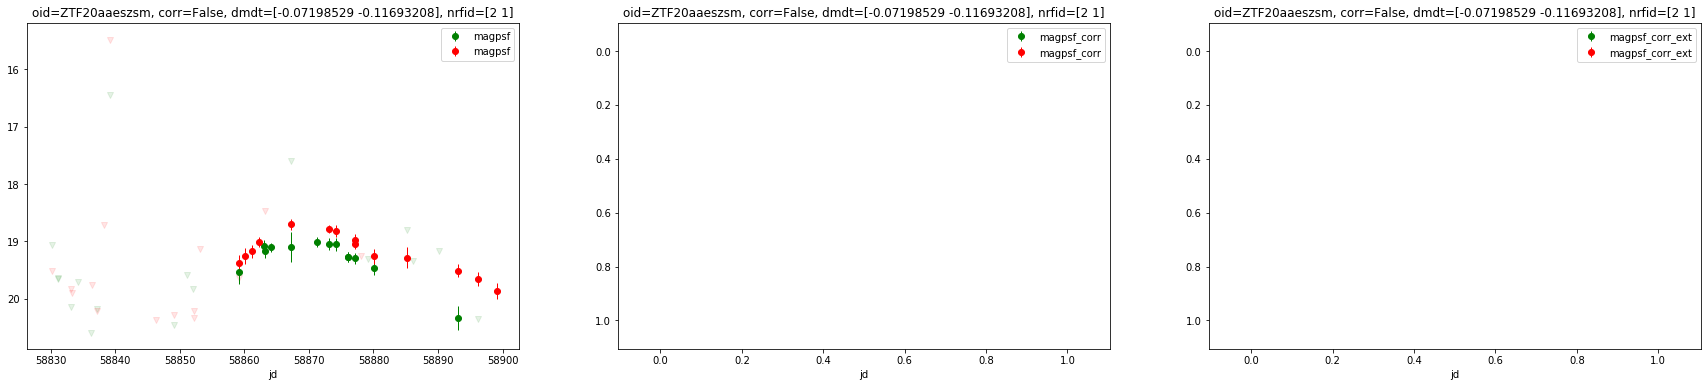

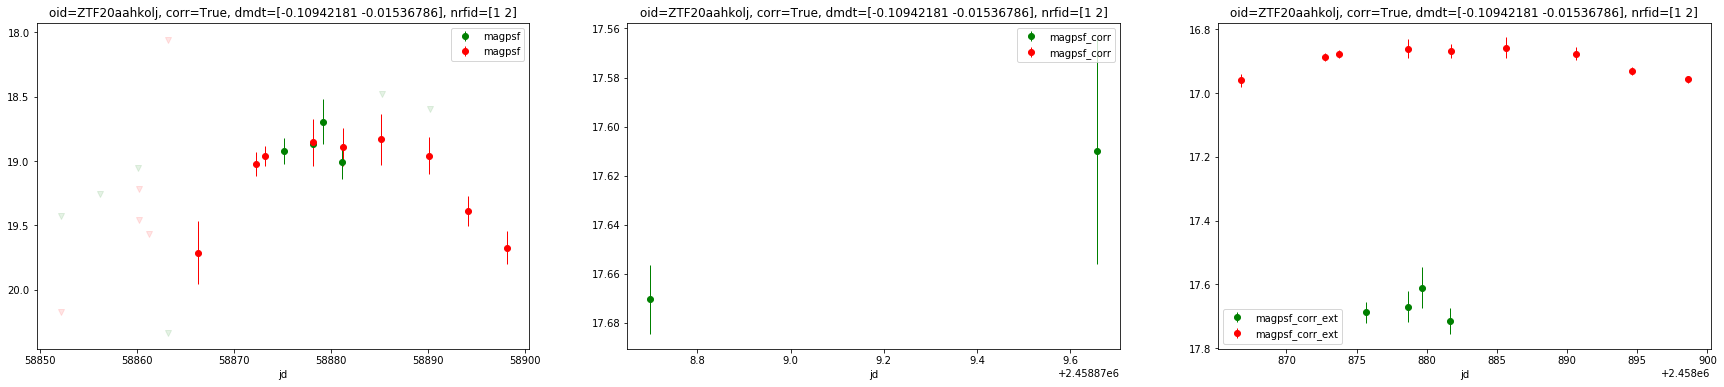

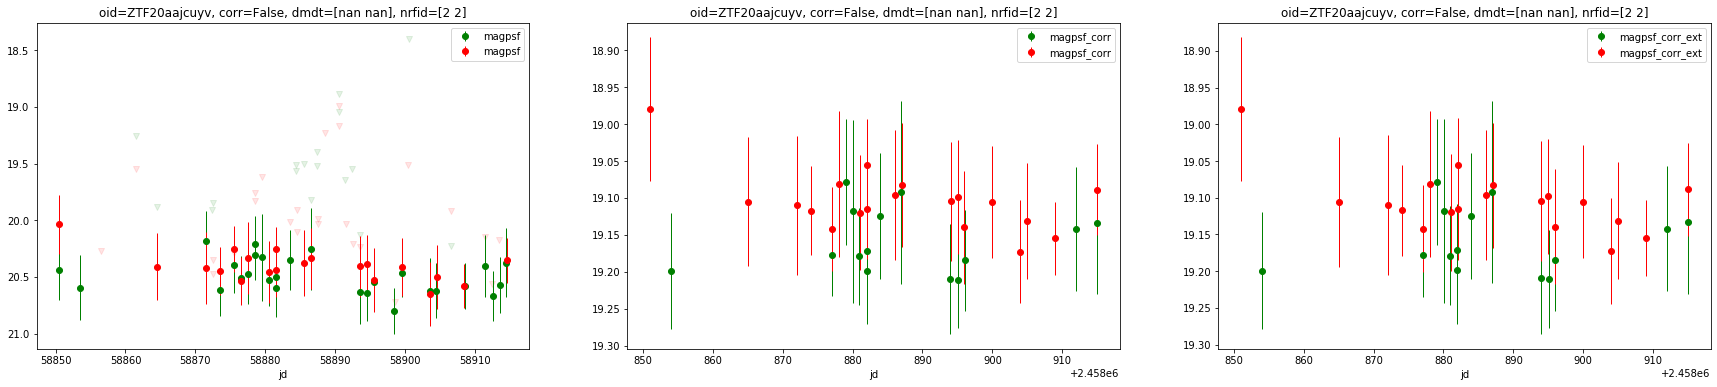

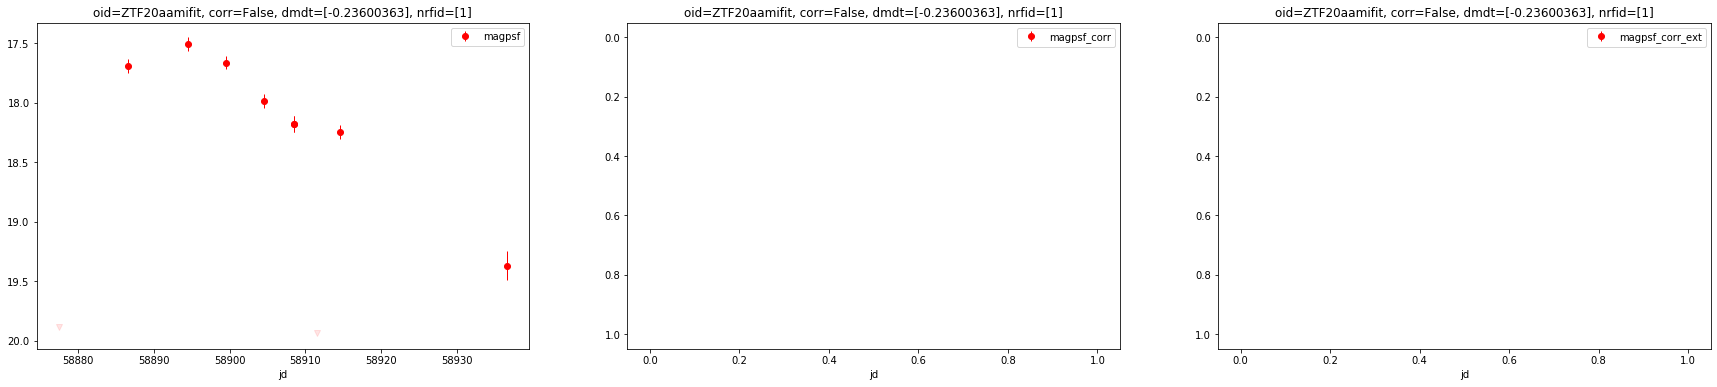

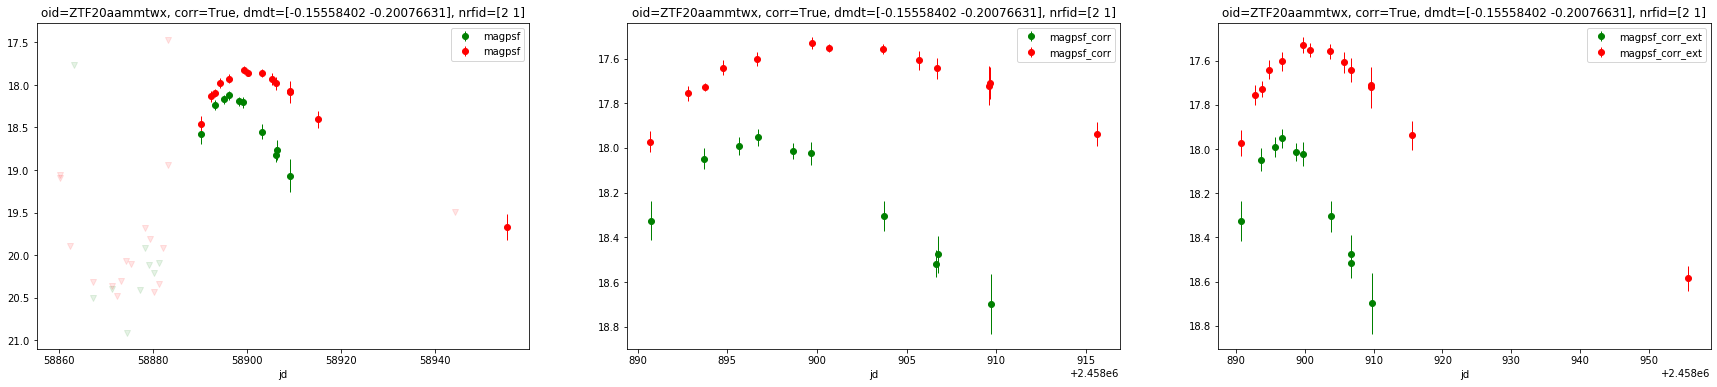

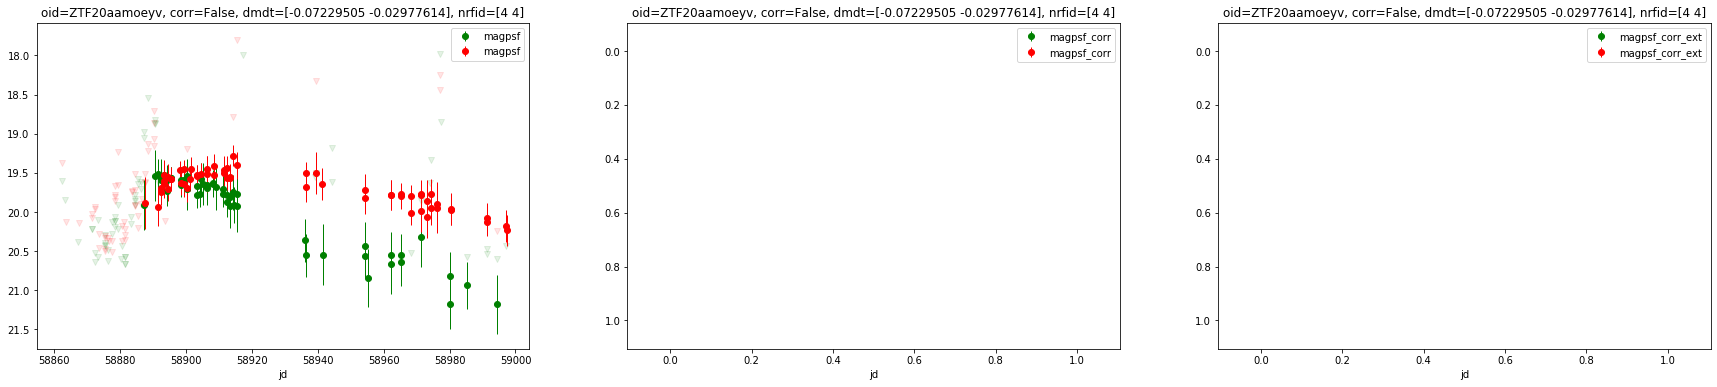

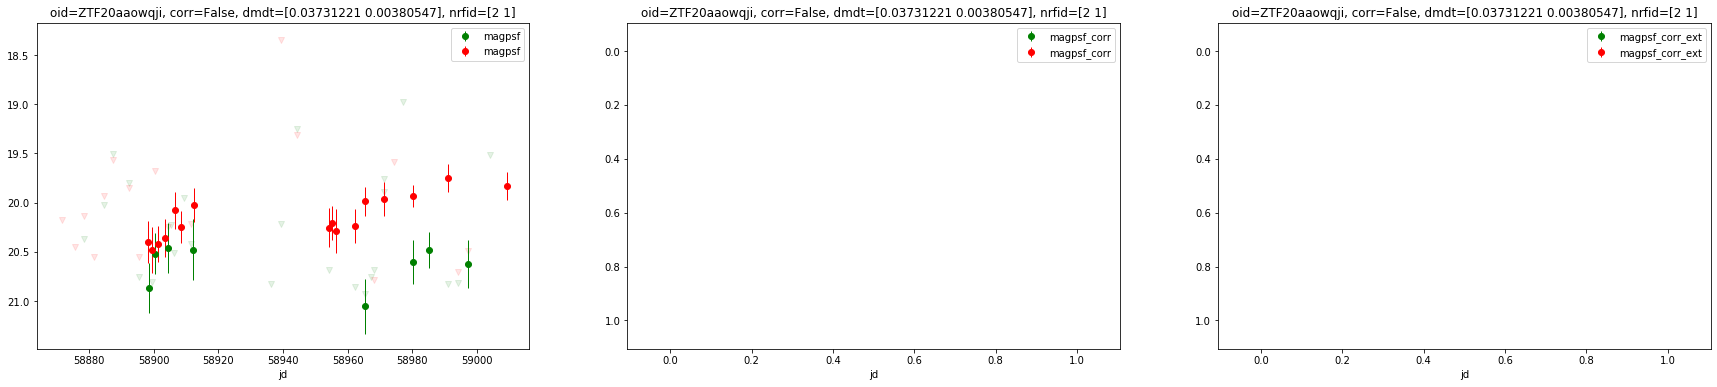

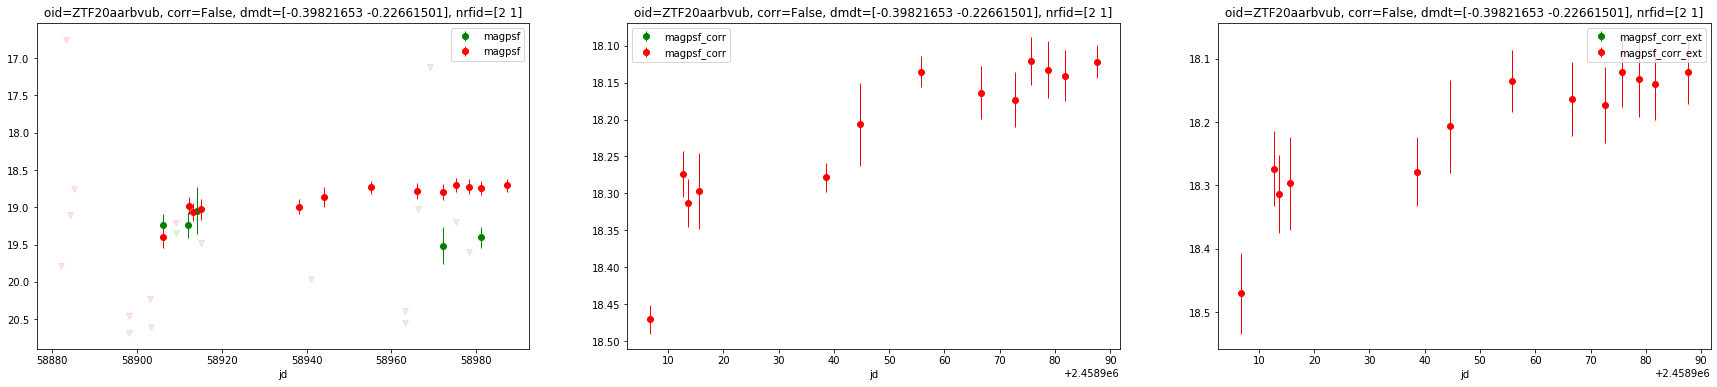

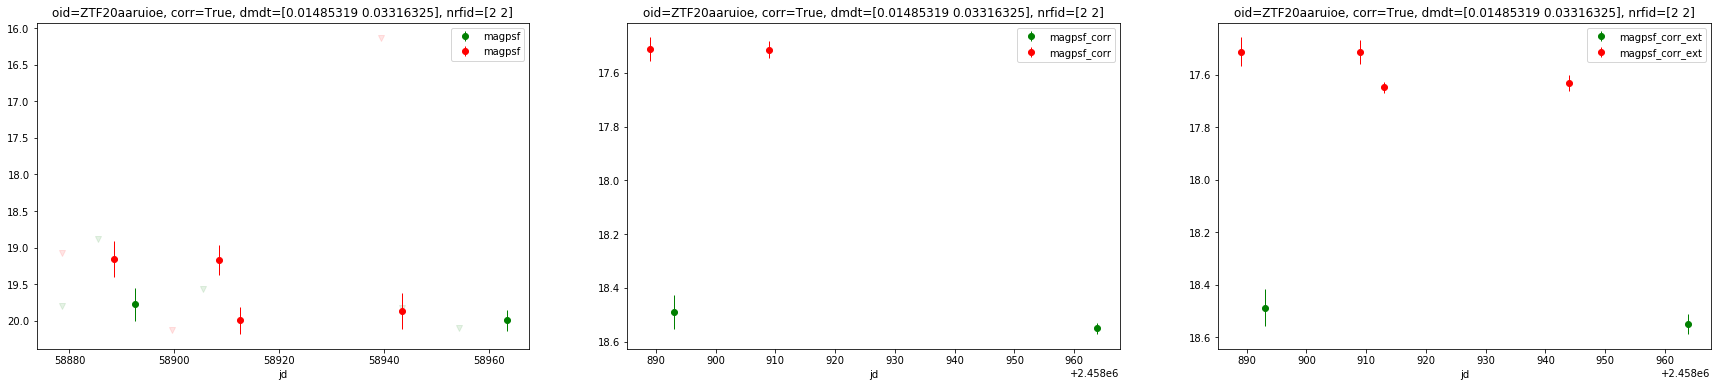

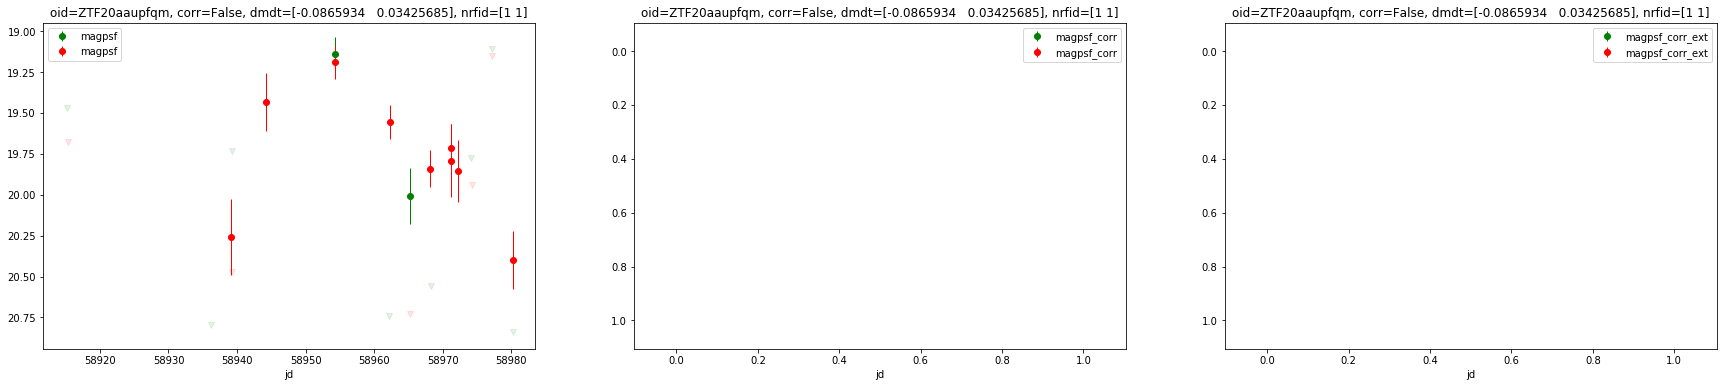

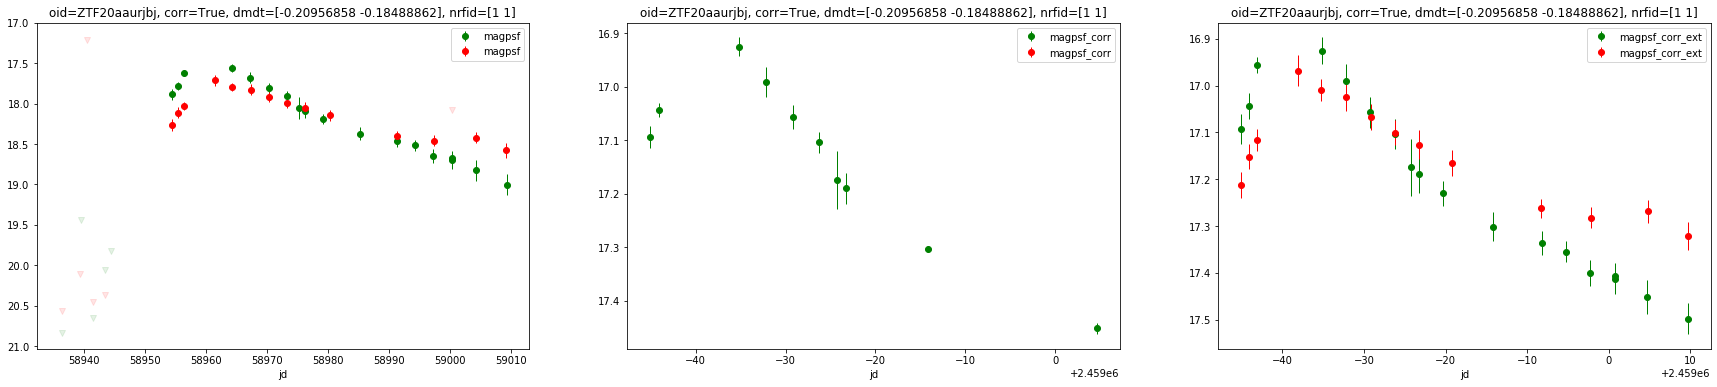

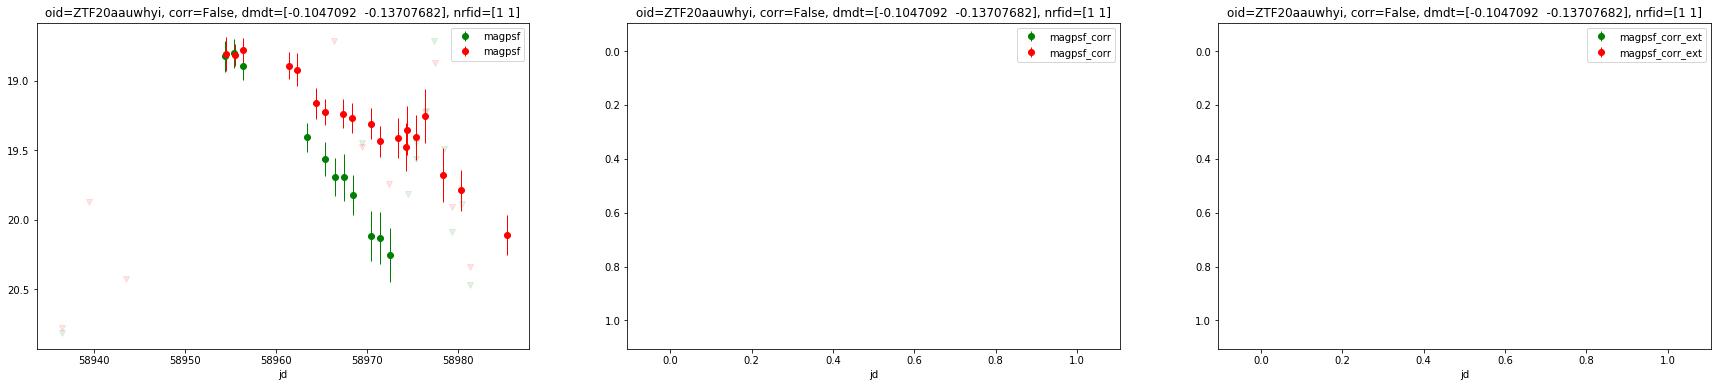

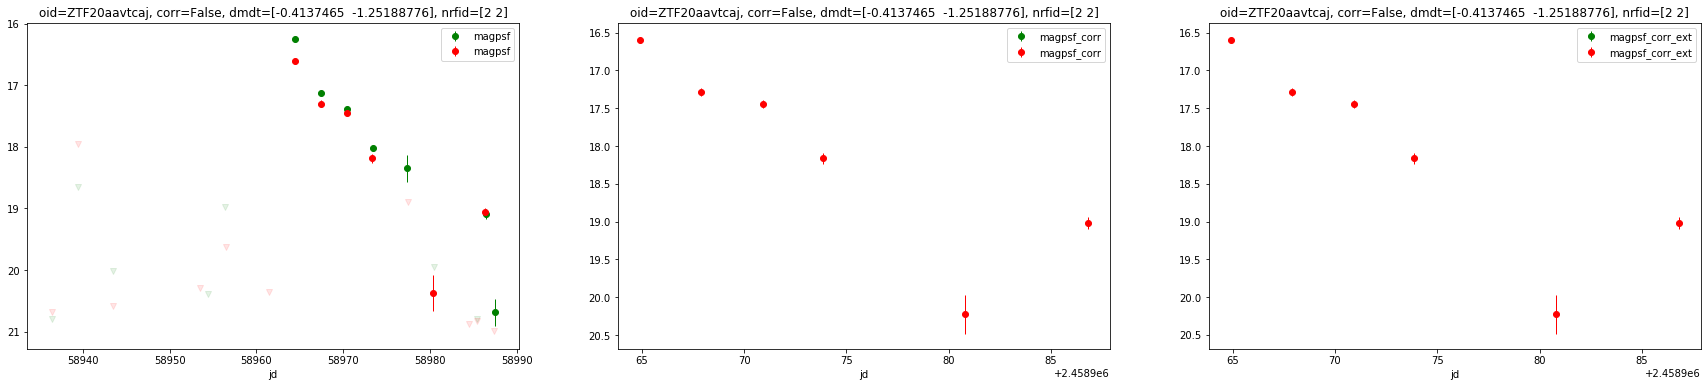

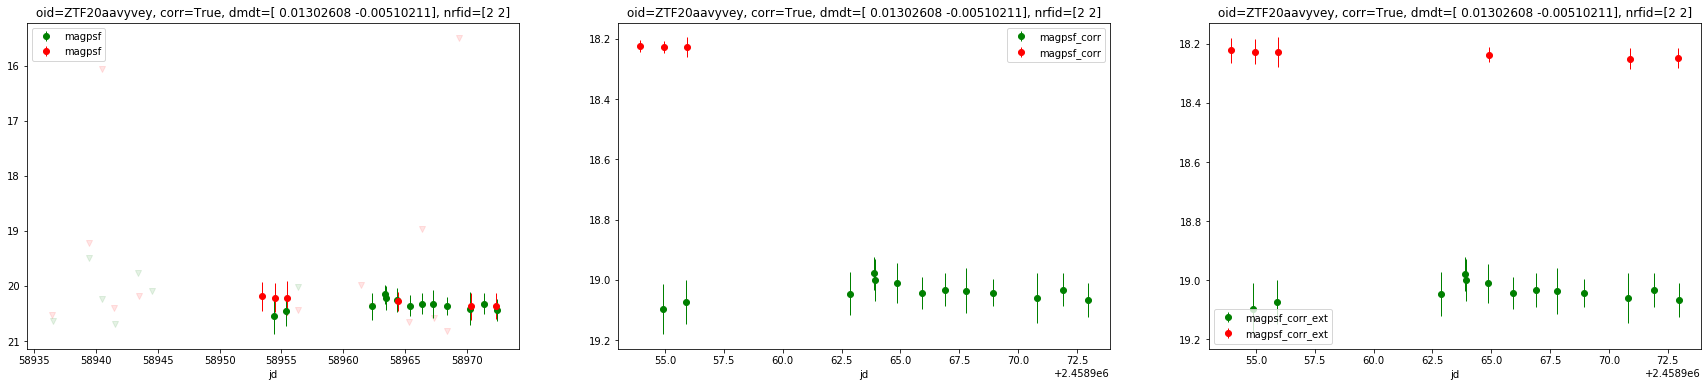

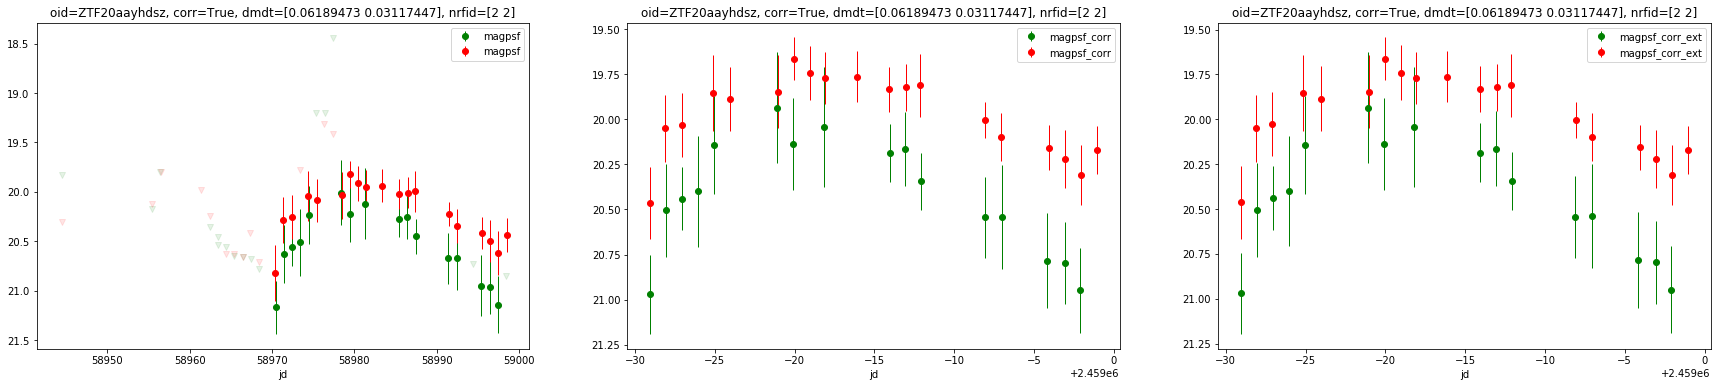

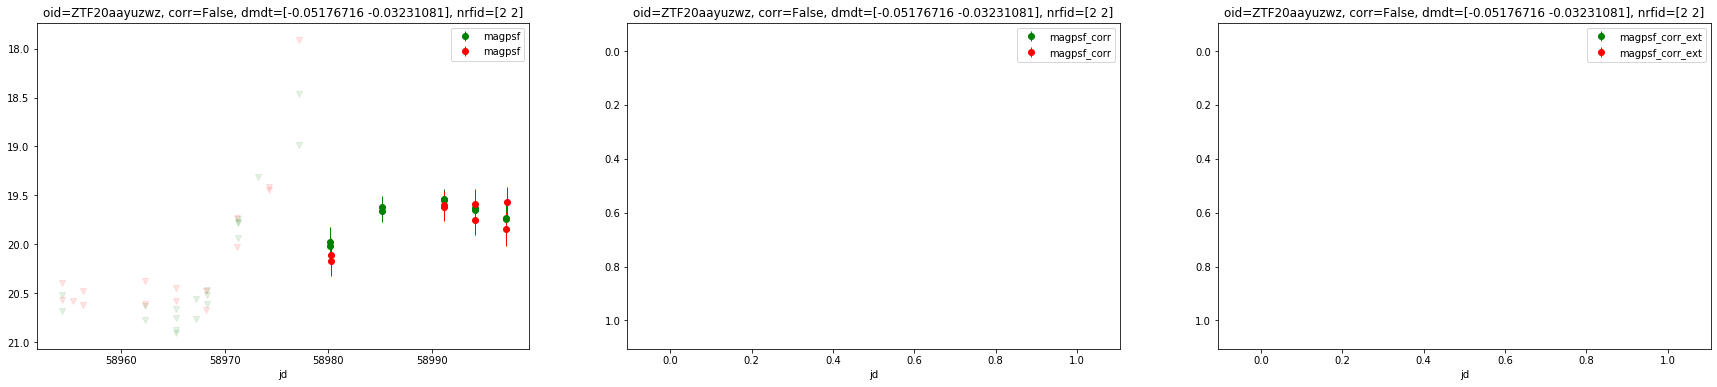

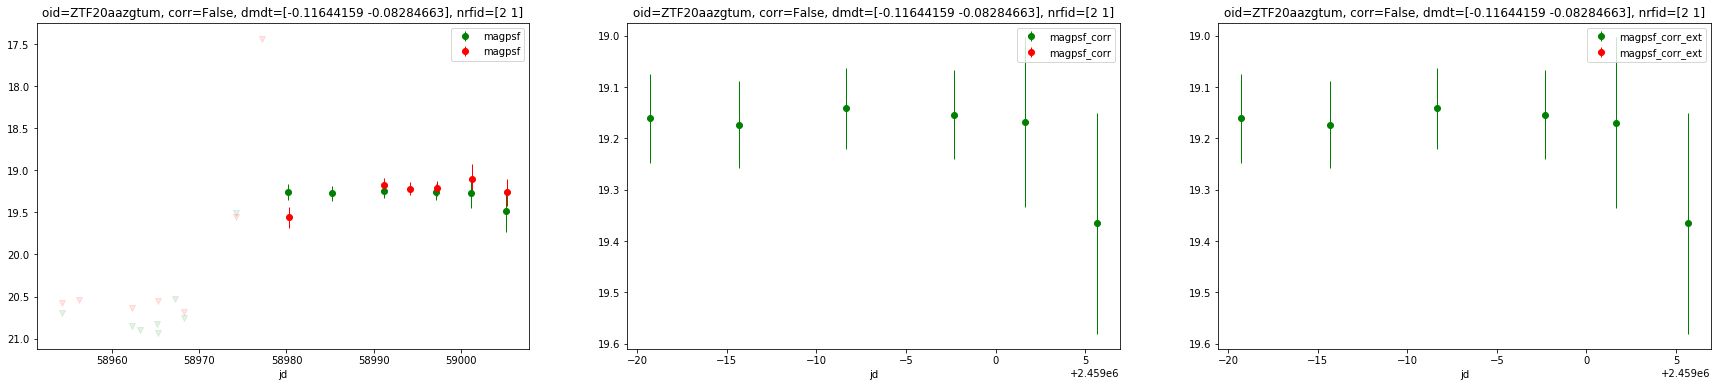

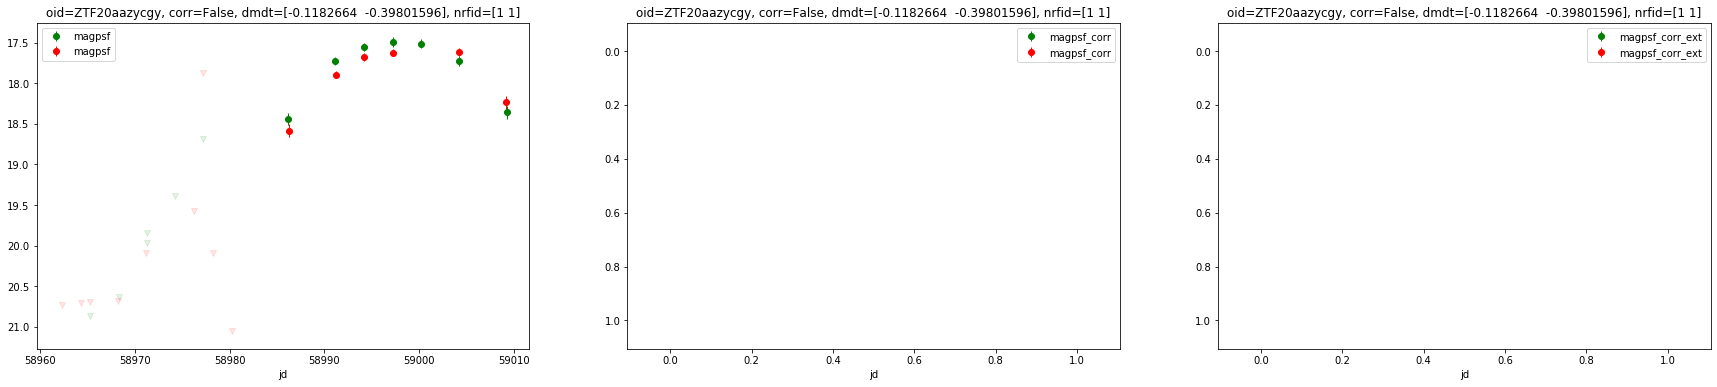

In [38]:
for idx, oid in enumerate(magstats.index.levels[0]):#sn.loc[sn.oid.isin(seloid)].oid):
    if idx < 100:
        print(oid)
        plot_object(oid)

In [39]:
list(magstats.loc[magstats.dmdt_first < -1].index)

[('ZTF18abxcdaa', 1),
 ('ZTF19abfwxwe', 2),
 ('ZTF19abitrvw', 2),
 ('ZTF20aavtcaj', 2)]

ZTF18abxcdaa
ZTF19abfwxwe
ZTF19abitrvw
ZTF20aavtcaj


Text(0, 0.5, 'dmdt_first')

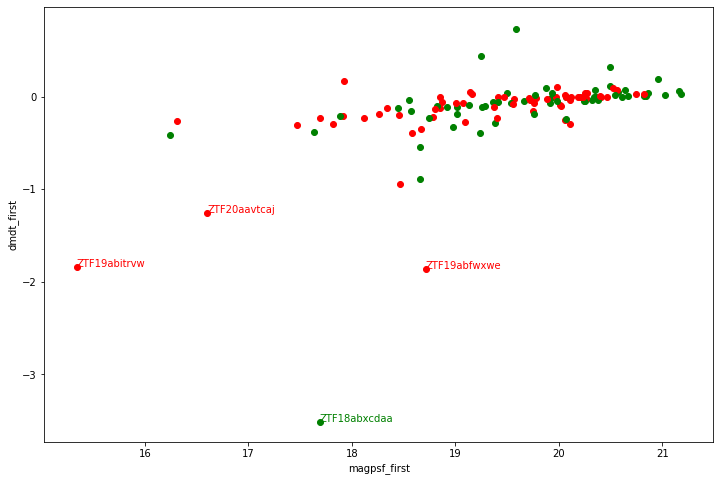

In [46]:
fig, ax = plt.subplots(figsize = (12, 8))
for oid, fid in list(magstats.index):
    color = 'g' if fid == 1 else 'r'
    ax.scatter(magstats.loc[oid, fid].magpsf_first, magstats.loc[oid, fid].dmdt_first, c=color)
    if magstats.loc[oid, fid].dmdt_first < -1:
        print(oid)
        ax.text(magstats.loc[oid, fid].magpsf_first, magstats.loc[oid, fid].dmdt_first, oid, c=color)
ax.set_xlabel("magpsf_first")
ax.set_ylabel("dmdt_first")

In [59]:
det.memory_usage(index=True).sum()

931512

In [60]:
non_det.memory_usage(index=True).sum()

38167

In [61]:
dflarge.memory_usage(index=True).sum()

969276

In [58]:
magstats.memory_usage(index=True).sum()

43009

In [62]:
objstats.memory_usage(index=True).sum()

4632